# Финальный проект: телекоммуникации
## Краткое описание проекта
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

**Задача:** обучить на модель для прогноза оттока клиентов. Необходимо выполнить задачу классификации.

### Описание услуг
Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

#### Файл `contract_new.csv`
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

#### Файл `personal_new.csv`

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

#### Файл `internet_new.csv`

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

#### Файл `phone_new.csv`
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.


## Загрузка данных
Загрузите данные и выполните их первичный осмотр.

In [2]:
!pip install phik

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import phik
import matplotlib.pyplot as plt
import seaborn as sns
import time
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [4]:
RANDOM_STATE = 301023

In [5]:
contracts = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate', 'EndDate'])

In [6]:
personal = pd.read_csv('/datasets/personal_new.csv')

In [7]:
internet = pd.read_csv('/datasets/internet_new.csv')

In [8]:
phone = pd.read_csv('/datasets/phone_new.csv')

In [9]:
def basic_data_info(data):
    """Функция, распечатывающая основную информацию о датефрейме"""
    print('Первые пять строк:')
    display(data.head())
    print('\nИнформация:')
    print(data.info())
    print('\nНаличие пропусков:')
    print(data.isna().sum())
    print('\nНаличие дубликатов:')
    print(data.duplicated().sum())
    print('\nСтатистическое описание данных:')
    display(data.describe())

In [10]:
basic_data_info(contracts)

Первые пять строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
None

Наличие пропусков:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Наличие дубликатов:
0

Статистическое описание данных

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [11]:
basic_data_info(personal)

Первые пять строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Наличие пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Наличие дубликатов:
0

Статистическое описание данных:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [12]:
basic_data_info(internet)

Первые пять строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Наличие пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Наличие дубликатов:
0

Статистическое описание данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [13]:
basic_data_info(phone)

Первые пять строк:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Наличие пропусков:
customerID       0
MultipleLines    0
dtype: int64

Наличие дубликатов:
0

Статистическое описание данных:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Данные были загружены в 4 датафрейма: `contracts`, `personal`, `internet`, `phone`. Ни в одной из датафреймов нет явных пропусков и дубликатов.

Датафрейм `contracts` содержит 7043 строк и 8 столбцов. Описание столбцов представлено в предыдущем пункте. Стоит отметить, что тип данных в некоторых столбцах отличается от ожидаемого, в частности в столбцах `EndDate` и `TotalCharges` - ожидаются типы `datetime` и `float` соответственно, но в данных данные строковые.

Датафрейм `personal` содержит 7043 строк и пять колонок.

Датафрейм `internet` содержит 5517 строк и восемь колонок, соответствубщих типам услуг.

Датафрейм `phone` содержит 6361 строк и 2 колонки.

## Исследовательский анализ и предобработка данных

### Датафрейм `contracts`
Еще раз изучим информацию о датафрейме. Из предыдущего пункта знаем, что в датафрейме нет явных пропусков (NaN) и полных дубликатов.

In [14]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


Целевой признак неочевидным образом содержится в колонке `EndDate`: если есть дата окончания договора, значит клиент отказался от услуг. Если же даты нет, то клиент (пока) не отказался от услуг. Выделим целевой признак в отдельную колонку явным образом.

In [15]:
def ended_contract(value: str) -> int:
    if value == 'No':
        return 0
    else: 
        return 1

In [16]:
def return_days(td) -> int:
    return td.days

In [17]:
contracts['EndedContract'] = contracts['EndDate'].apply(ended_contract)

In [18]:
contracts.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndedContract
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


Теперь заменим в колонке `EndDate` значение `No` на дату выгрузки данных - 1 февраля 2020 года. Затем приведем данные к типу `datetime`. Это нужно сделать, чтобы мы могли выделить новый признак - длительность контракта. Далее приведем значения в новом столбце к типу `int`.

In [19]:
contracts['EndDate'] = contracts['EndDate'].replace('No', '2020-02-01')

In [20]:
contracts['EndDate'] = pd.to_datetime(contracts['EndDate'])

In [21]:
contracts['ContractLength'] = contracts['EndDate'] - contracts['BeginDate']

In [22]:
contracts['ContractLength'] = contracts['ContractLength'].apply(return_days)

In [23]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndedContract,ContractLength
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


Теперь посмотрим на колонку `TotalCharges`. В ней должны быть числовые данные типа `float`, но на деле хранятся строковые данные.

In [24]:
contracts['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: TotalCharges, Length: 6658, dtype: int64

In [25]:
contracts[contracts['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndedContract,ContractLength
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


Видим, что в столбце `TotalCharges` содержатся неявные пропуски в тем случаях, когда дата начала действия договора совпадает с датой выгрузки данных. Предлагаю удалить такие строки из данных.

In [26]:
contracts = contracts[contracts['TotalCharges'] != ' '].reset_index(drop=True)

In [27]:
contracts['TotalCharges'] = contracts['TotalCharges'].astype('float64')

In [28]:
contracts.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndedContract,ContractLength
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


In [29]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   EndedContract     7032 non-null   int64         
 9   ContractLength    7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 549.5+ KB


Таким образом, мы удалили неявные дубликаты в колонке `TotalCharges`, преобразовали данные к типу `datetime` в колонке `EndTime`, привели данные в колонке `TotalCharges` к типу `float` и выделили два новых признака: целевой признак `EndedContract` и признак `ContractLength`.

### Датафрейм `personal`
Преобразуем данные в колонке `SeniorCitizen` в строковые: это категориальный признак.

In [30]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [31]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

In [32]:
personal['SeniorCitizen'].value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

Проверим наличие неявных пропусков или необычных значений в других столбцах.

In [33]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


In [34]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [35]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [36]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

В данных нет неявных пропусков.

### Датафрейм `internet`
Датафрейм состоит из категориальных признаков. Данные не содержат явных пропусков и дубликатов. Проверим данные на наличие неявных пропусков и необычных значений.

In [37]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [38]:
internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [39]:
internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [40]:
internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [41]:
internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [42]:
internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [43]:
internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

В данных нет аномальных значений/неявных пропусков.

### Датафрейм `phone`
Датафрейм состоит из категориальных признаков. Данные не содержат явных пропусков и дубликатов. Проверим данные на наличие неявных пропусков.

In [44]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

В данных нет неявных пропусков.

### Выводы по этапу исследовательского анализа и предобработки отдельных датафреймов
Было изучено четыре датафрейма.
1. Датайрейм `contracts`. Мы удалили неявные дубликаты в колонке `TotalCharges`, преобразовали данные к типу `datetime` в колонке `EndTime`, привели данные в колонке `TotalCharges` к типу `float` и выделили два новых признака: целевой признак `EndedContract` и признак `ContractLength`.
2. Датафрейм `personal`. Значения в колонке `SeniorCitizen` были заменены на `Yes` и `No`. Была проведена проверка на наличие неявных дубликатов.
3. Датафрейм `internet`. Была проведена проверка на наличие неявных дубликатов.
4. Датафрейм `phone`. Была проведена проверка на наличие неявных дубликатов.

## Объединение данных
Объединим датафреймы по ключу `customerID`.

In [45]:
data_all = (contracts.merge(personal, on='customerID', how='left')
            .merge(internet, on='customerID', how='left')
            .merge(phone, on='customerID', how='left'))

In [46]:
basic_data_info(data_all)

Первые пять строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndedContract,ContractLength,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,...,No,No,Fiber optic,No,No,No,No,No,No,No



Информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   EndedContract     7032 non-null   int64         
 9   ContractLength    7032 non-null   int64         
 10  gender            7032 non-null   object        
 11  SeniorCitizen     7032 non-null   object        
 12  Partner           7032 non-null   object        
 13  Dependents        7032 non-null   object        
 14  InternetSer

,MonthlyCharges,TotalCharges,EndedContract,ContractLength
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,0.156570,899.961320
std,30.085974,2112.736199,0.363421,682.738777
min,18.250000,19.050000,0.000000,28.000000
25%,35.587500,439.745000,0.000000,276.000000
50%,70.350000,1345.275000,0.000000,761.000000
75%,89.862500,3239.317500,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,2314.000000


Мы объединили данные из четырех датафреймов по ключу `customerID`. Видим, что теперь в данных появились пропуски, которые нужно будет обработать на следующем этапе.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Обработка пропусков
После объединения датафреймов обнаружились пропуски в следующих колонках:
- `InternetService`: 1520 пропусков
- `OnlineSecurity`: 1520 пропусков 
- `OnlineBackup`: 1520 пропусков
- `DeviceProtection`: 1520 пропусков 
- `TechSupport`: 1520 пропусков
- `StreamingTV`: 1520 пропусков
- `StreamingMovies`: 1520 пропусков
- `MultipleLines`: 680 пропусков

Мы можем заполнить эти пропуски заглушками: `no_internet` для пропусков, пришедших из датафрейма `internet` и `no_phone` для пропусков из `phone`.

In [47]:
data_all[internet.columns] = data_all[internet.columns].fillna('no_internet')

In [48]:
data_all[phone.columns] = data_all[phone.columns].fillna('no_phone')

In [49]:
data_all.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
EndedContract       0
ContractLength      0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

### Исследовательский анализ данных

В данных есть следующие категориальные признаки:
- `Type`
- `PaperlessBilling`
- `PaymentMethod`
- `EndedContract` - целевой признак
- `gender`
- `SeniorCitizen`
- `Partner`
- `Dependents` 
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`
- `MultipleLines`

Следующие признаки являются интервальными:
- `ContractLength`
- `MonthlyCharges`
- `TotalCharges`

Значения в колонке `customerID` нужны для идентификации пользователей, но не несут полезной информации для обучения модели. На базе признаков `BeginDate` и `EndDate` был создан новый признак `ContractLength`, поэтому их можно исключить из рассмотрения.

In [50]:
data_all = data_all.drop(['BeginDate', 'EndDate'], axis=1).set_index('customerID')

In [51]:
def analyse_categorical_feature(feature_name: str, plt_title: str = None):
    """Функция для визуализации информации о категориальном признаке."""
    fig, ax = plt.subplots(figsize=(12,8))  
    sns.countplot(data=data_all, x=feature_name)
    plt.title(plt_title)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,8)) 
    sns.countplot(data=data_all, x=feature_name, hue='EndedContract')
    plt.title(plt_title)
    plt.show()
    
    print('Относительное число пользователей, отказавшихся от услуг:')
    for v in data_all[feature_name].unique():
        n = data_all[data_all[feature_name] == v].shape[0]
        ended_contract = data_all[(data_all[feature_name] == v) & (data_all['EndedContract'] == 1)].shape[0]
        continued_contract = data_all[(data_all[feature_name] == v) & (data_all['EndedContract'] == 0)].shape[0]
        print(f'''
        {v}:
        \tОтказались от услуг: {round((ended_contract * 100/n), 2)}%
        \tНе отказались от услуг: {round((continued_contract * 100/n), 2)}%''')

#### Целевой признак `EndedContract`

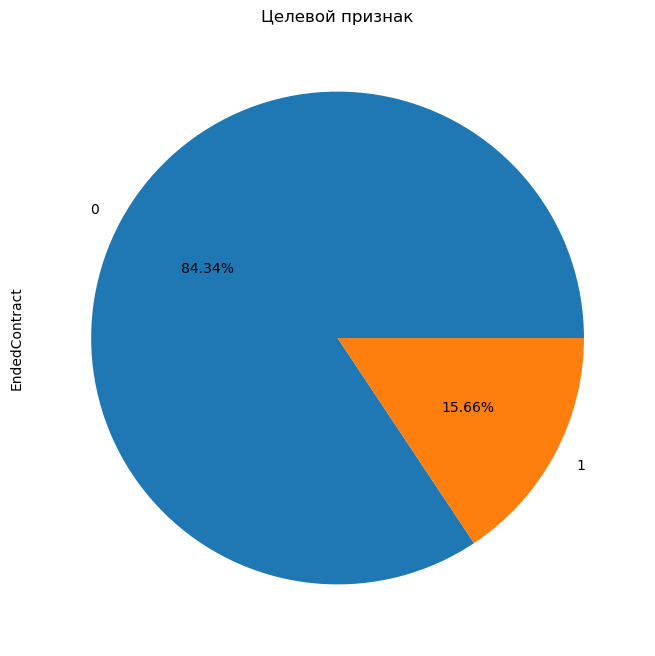

In [52]:
data_all['EndedContract'].value_counts().plot(kind='pie', figsize=(15,8), title='Целевой признак', autopct='%.2f%%');

В данных наблюдается дисбаланс классов: большая часть пользователей не разрывала контракт.

#### Признак `Type`

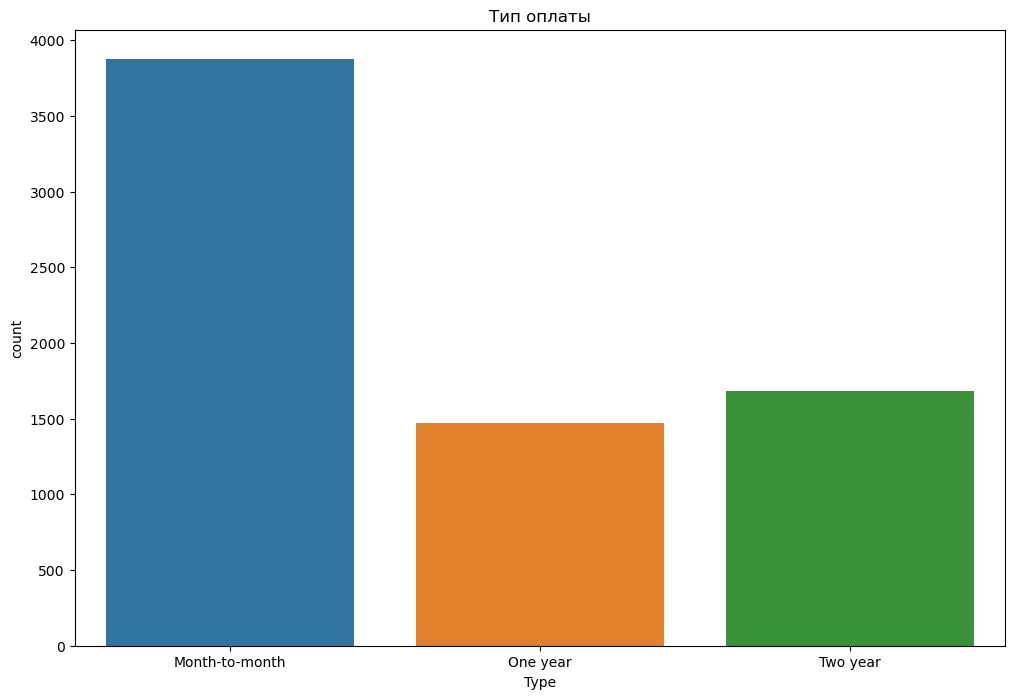

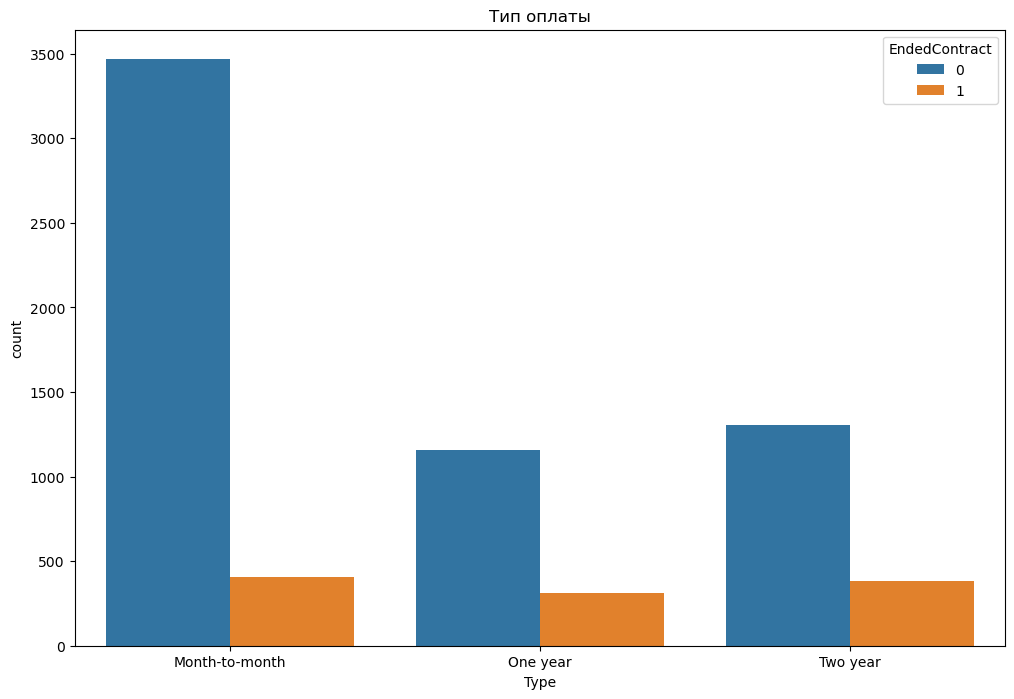

Относительное число пользователей, отказавшихся от услуг:

        Month-to-month:
        	Отказались от услуг: 10.5%
        	Не отказались от услуг: 89.5%

        One year:
        	Отказались от услуг: 21.26%
        	Не отказались от услуг: 78.74%

        Two year:
        	Отказались от услуг: 22.61%
        	Не отказались от услуг: 77.39%


In [53]:
analyse_categorical_feature('Type', 'Тип оплаты')

Большинство пользователей платят ежемесячно. Абсолютное число пользователей, отказавшихся от услуг, не сильно различается по типам оплаты, однако относительные значения различаются. Таким образом, пользователи, которые платят раз в год или раз в два года оказались более склонны к тому, чтобы отказываться от услуг.

#### Признак `PaperlessBilling`

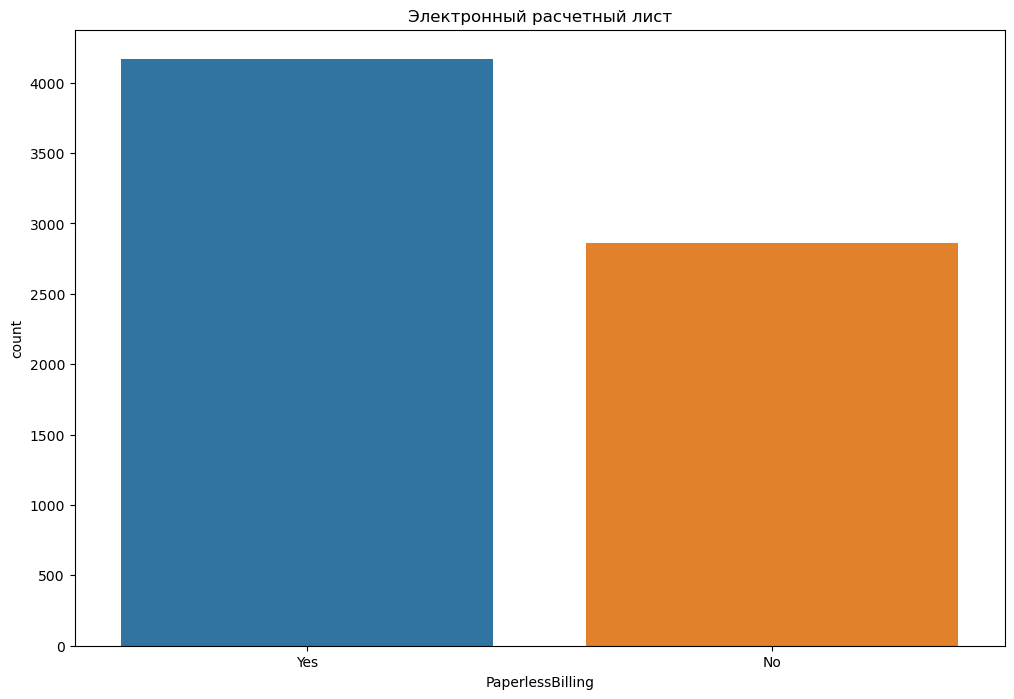

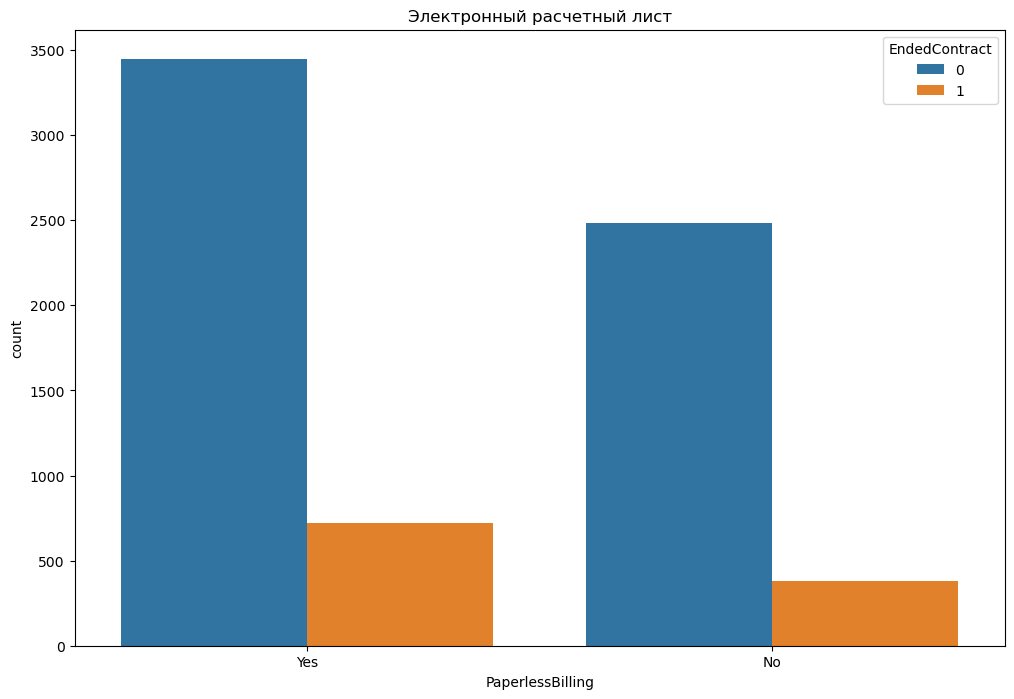

Относительное число пользователей, отказавшихся от услуг:

        Yes:
        	Отказались от услуг: 17.3%
        	Не отказались от услуг: 82.7%

        No:
        	Отказались от услуг: 13.27%
        	Не отказались от услуг: 86.73%


In [54]:
analyse_categorical_feature('PaperlessBilling', 'Электронный расчетный лист')

Видим, что б*о*льшая часть пользователей пользуется электронным рассчтным листом. При этом относительное число пользователей, отказавшихся от услуг, не сильно отличается между этими категориями.

#### Признак `PaymentMethod`

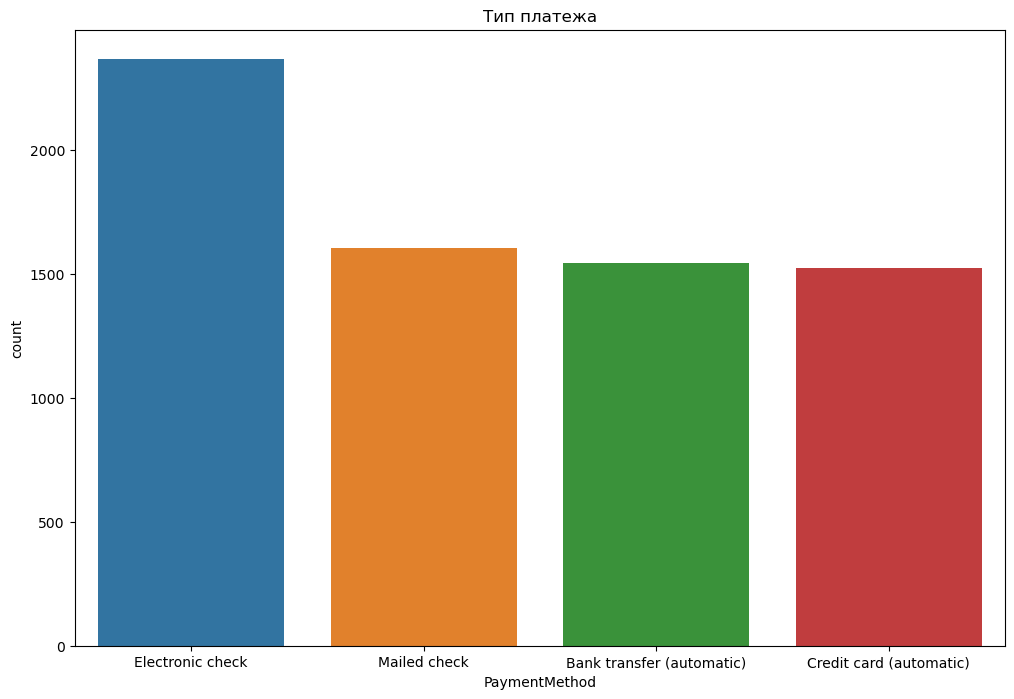

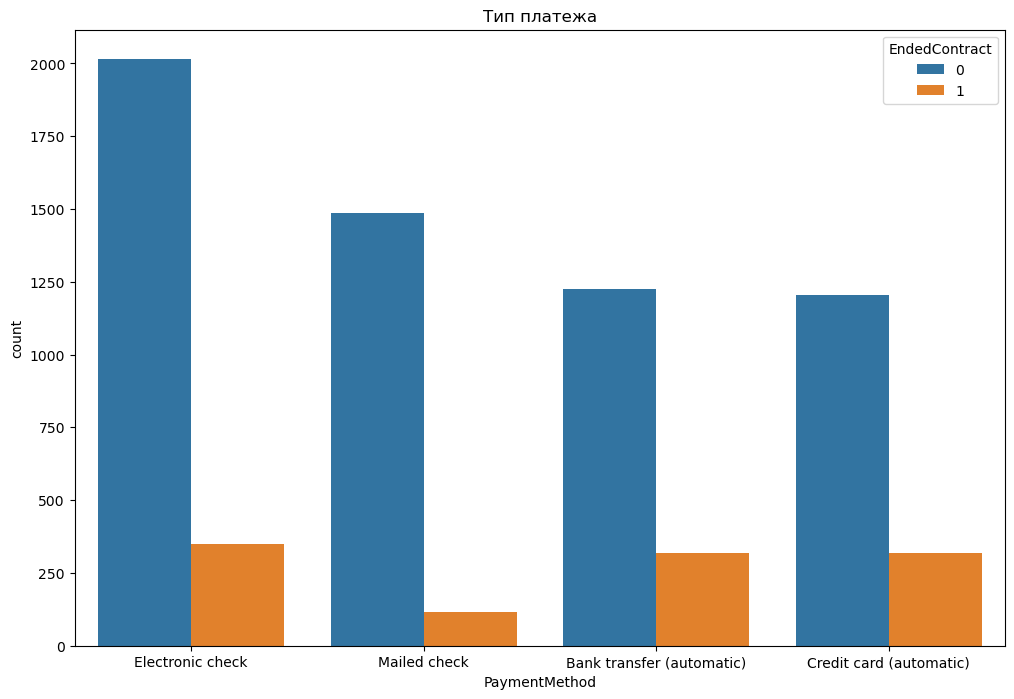

Относительное число пользователей, отказавшихся от услуг:

        Electronic check:
        	Отказались от услуг: 14.8%
        	Не отказались от услуг: 85.2%

        Mailed check:
        	Отказались от услуг: 7.29%
        	Не отказались от услуг: 92.71%

        Bank transfer (automatic):
        	Отказались от услуг: 20.56%
        	Не отказались от услуг: 79.44%

        Credit card (automatic):
        	Отказались от услуг: 20.84%
        	Не отказались от услуг: 79.16%


In [55]:
analyse_categorical_feature('PaymentMethod', 'Тип платежа')

Большинство пользователей предпочитает платить с помощью электронного чека. Пользователи, которые платят отправкой чека, наименее склонны отказываться от услуг. Больше всего склонны отказываться от услуг пользователи, у которых оплата происходит автоматически.

#### Признак `gender`

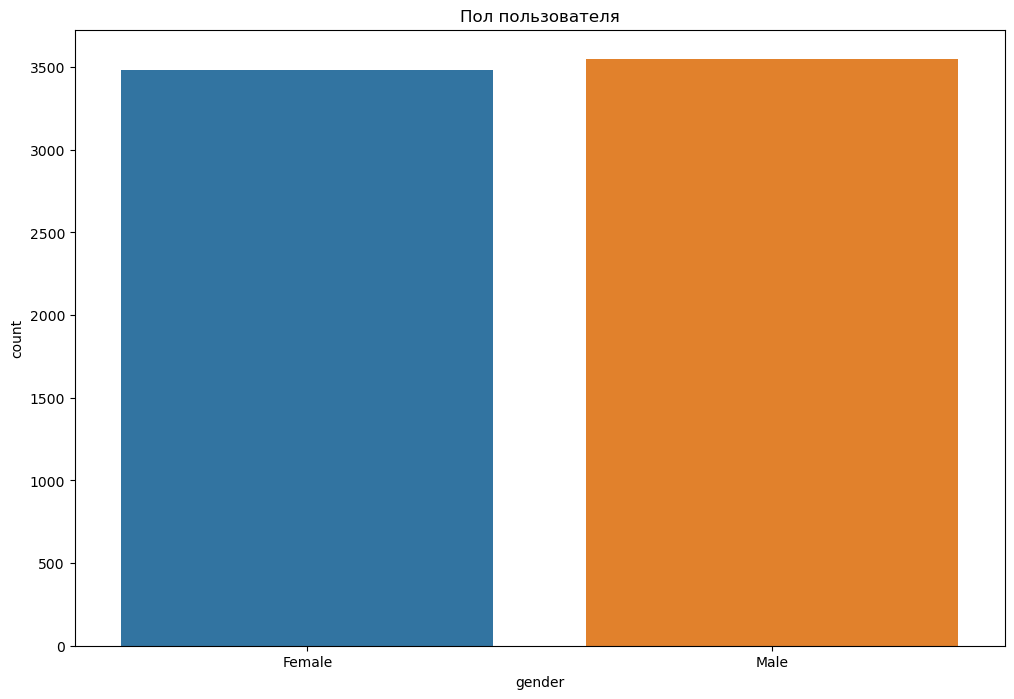

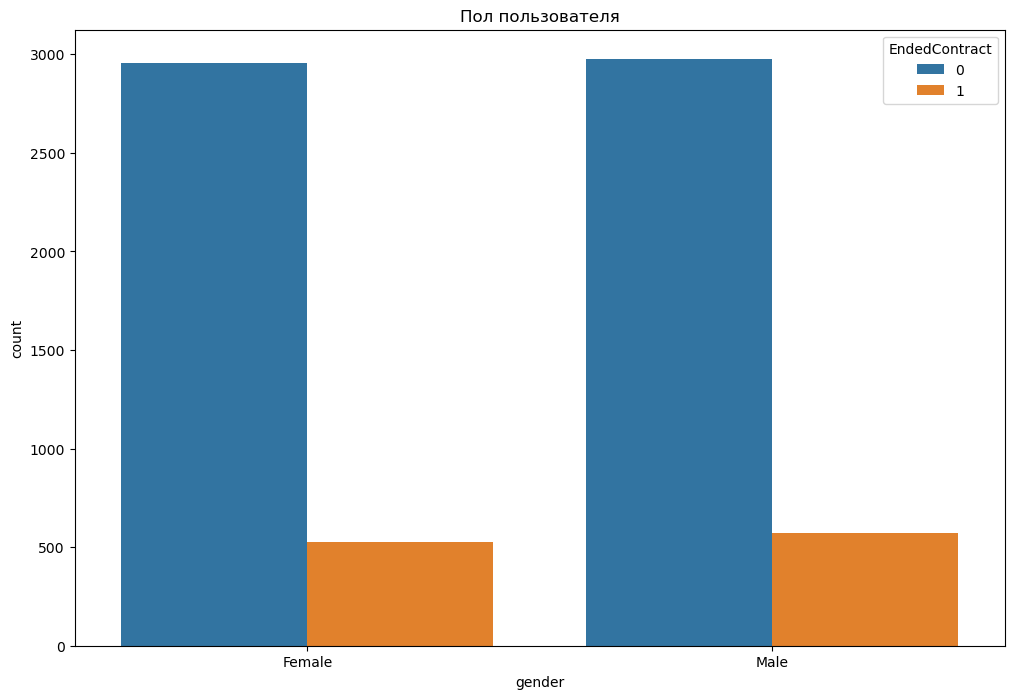

Относительное число пользователей, отказавшихся от услуг:

        Female:
        	Отказались от услуг: 15.16%
        	Не отказались от услуг: 84.84%

        Male:
        	Отказались от услуг: 16.15%
        	Не отказались от услуг: 83.85%


In [56]:
analyse_categorical_feature('gender', 'Пол пользователя')

Пользователи обоих полов равномерно представлены в выборке. Они отказываются от услуг с одинаковой частотностью.

#### Признак `SeniorCitizen`

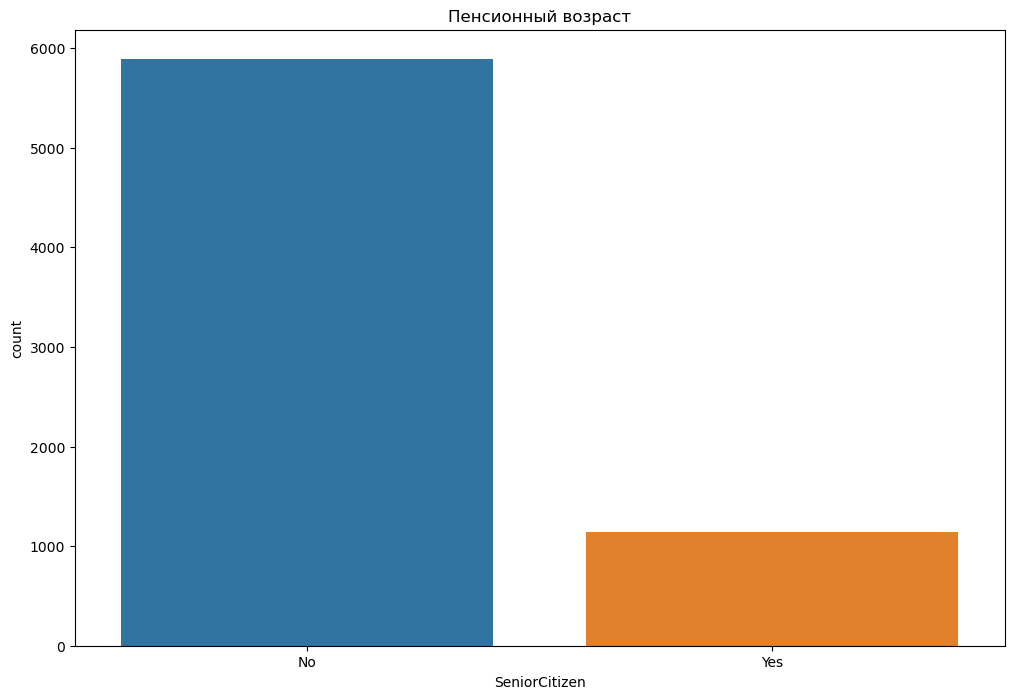

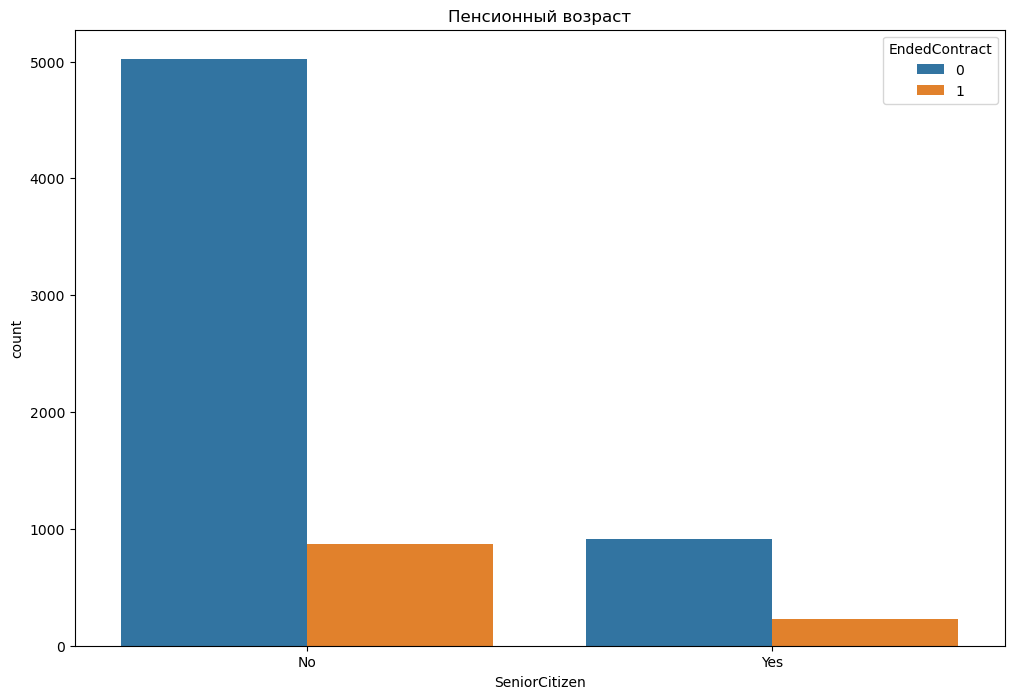

Относительное число пользователей, отказавшихся от услуг:

        No:
        	Отказались от услуг: 14.75%
        	Не отказались от услуг: 85.25%

        Yes:
        	Отказались от услуг: 20.32%
        	Не отказались от услуг: 79.68%


In [57]:
analyse_categorical_feature('SeniorCitizen', 'Пенсионный возраст')

Большинство пользователей не являются пенсионерами. Среди пенсионеров больше пользователей, который отказываются от услуг.

#### Признак `Partner`

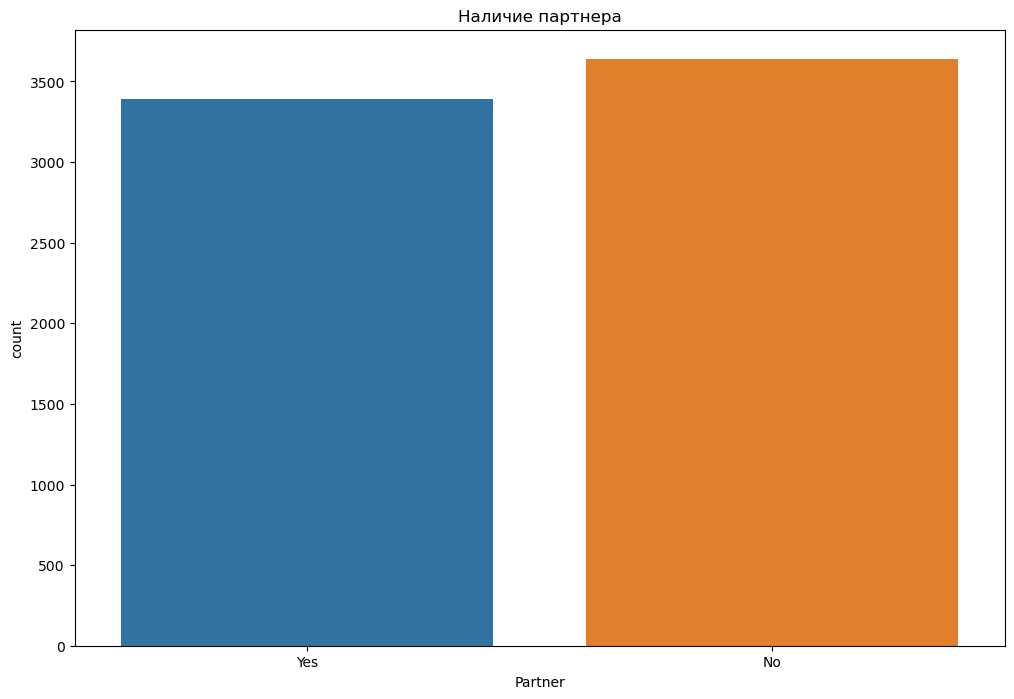

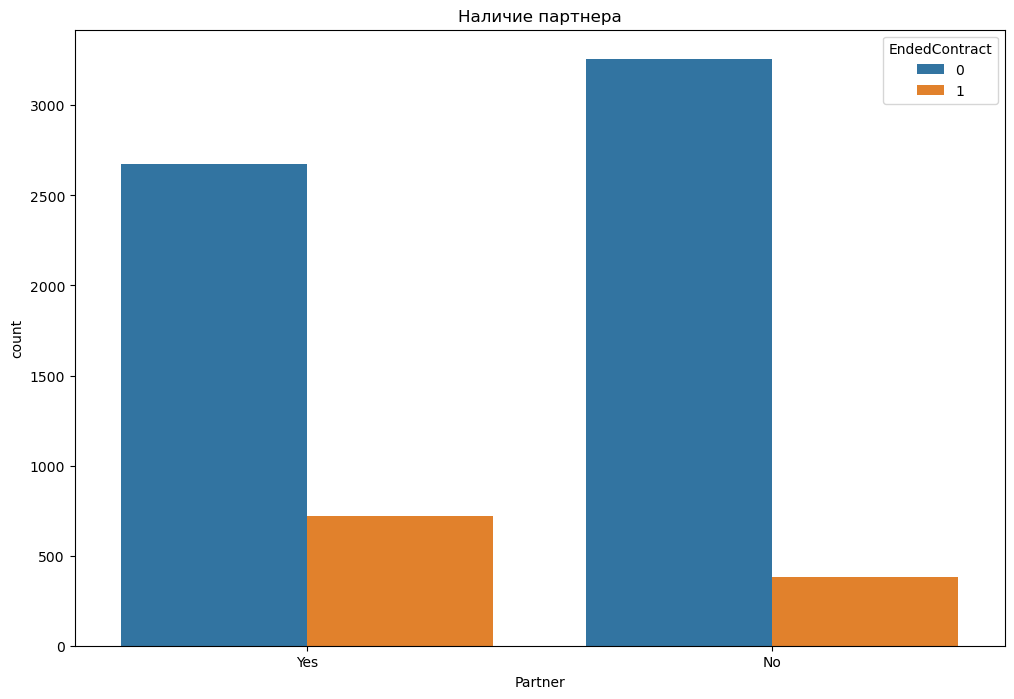

Относительное число пользователей, отказавшихся от услуг:

        Yes:
        	Отказались от услуг: 21.19%
        	Не отказались от услуг: 78.81%

        No:
        	Отказались от услуг: 10.5%
        	Не отказались от услуг: 89.5%


In [58]:
analyse_categorical_feature('Partner', 'Наличие партнера')

Среди пользователей, имеющих супруга или супругу, процент отказа от услуг выше.

#### Признак `Dependents`

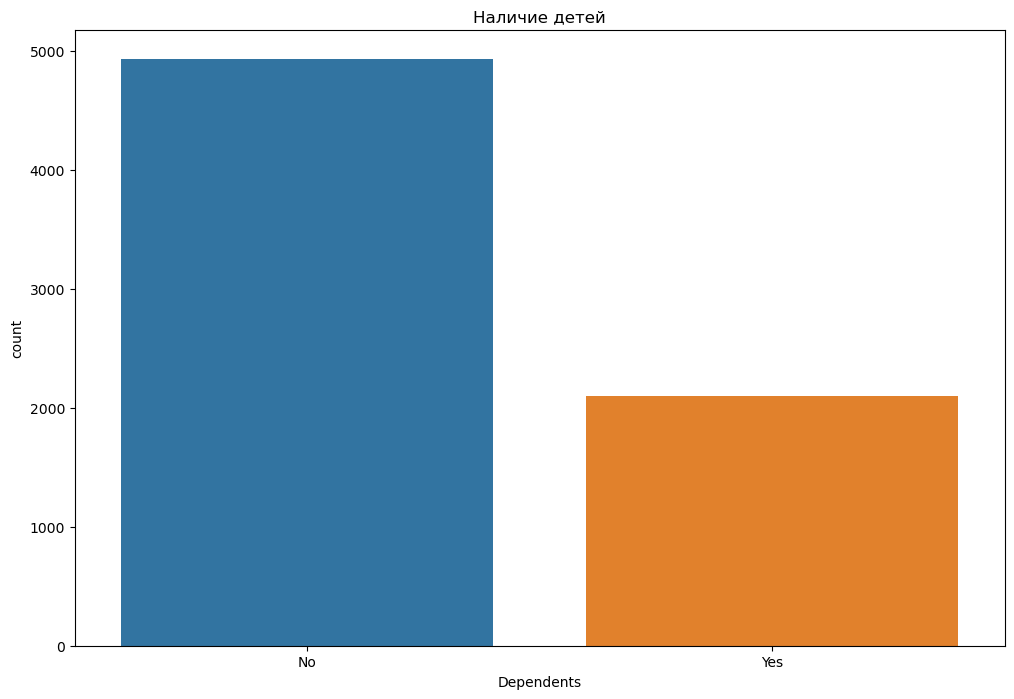

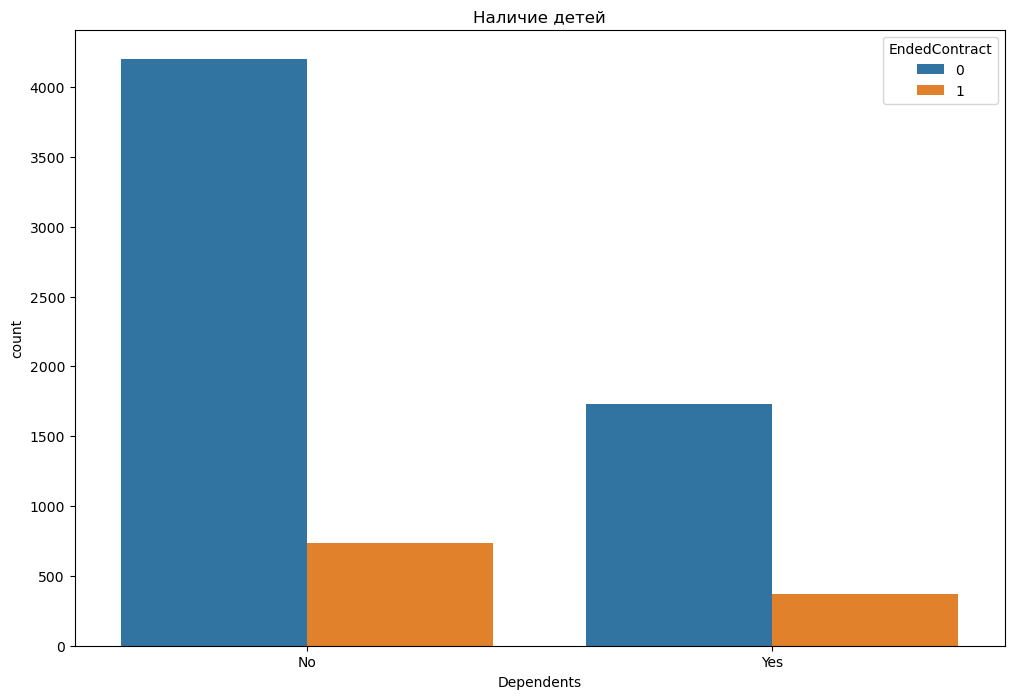

Относительное число пользователей, отказавшихся от услуг:

        No:
        	Отказались от услуг: 14.86%
        	Не отказались от услуг: 85.14%

        Yes:
        	Отказались от услуг: 17.53%
        	Не отказались от услуг: 82.47%


In [59]:
analyse_categorical_feature('Dependents', 'Наличие детей')

В данных преобладают пользователи, не имеющие детей. Относительное количество пользователей, имеющих детей и отказавшихся от услуг, чуть выше.

#### Признак `InternetService`

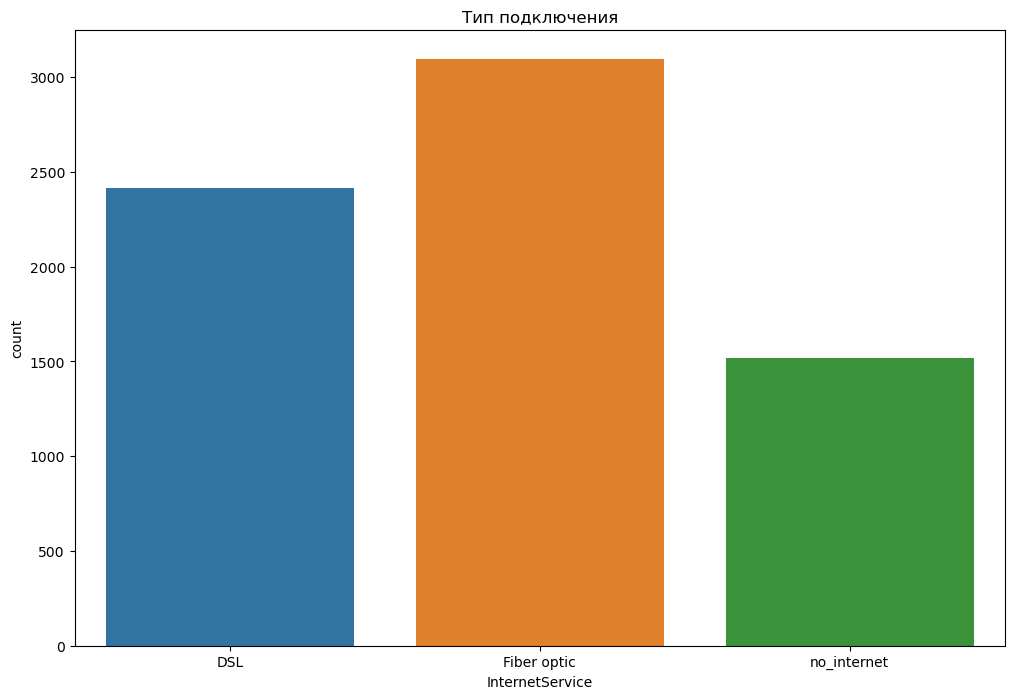

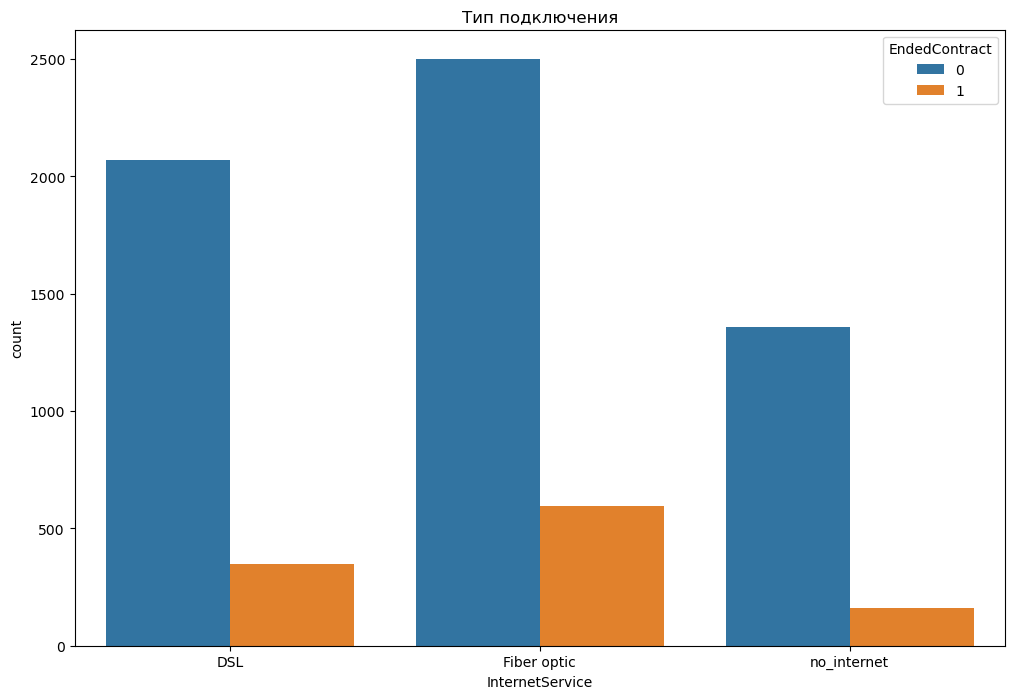

Относительное число пользователей, отказавшихся от услуг:

        DSL:
        	Отказались от услуг: 14.32%
        	Не отказались от услуг: 85.68%

        Fiber optic:
        	Отказались от услуг: 19.22%
        	Не отказались от услуг: 80.78%

        no_internet:
        	Отказались от услуг: 10.53%
        	Не отказались от услуг: 89.47%


In [60]:
analyse_categorical_feature('InternetService', 'Тип подключения')

Среди пользователей преобладают пользователи, выбравшие оптоволоконное подключение. Они же чаще отказываются от услуг.

#### Признак `OnlineSecurity`

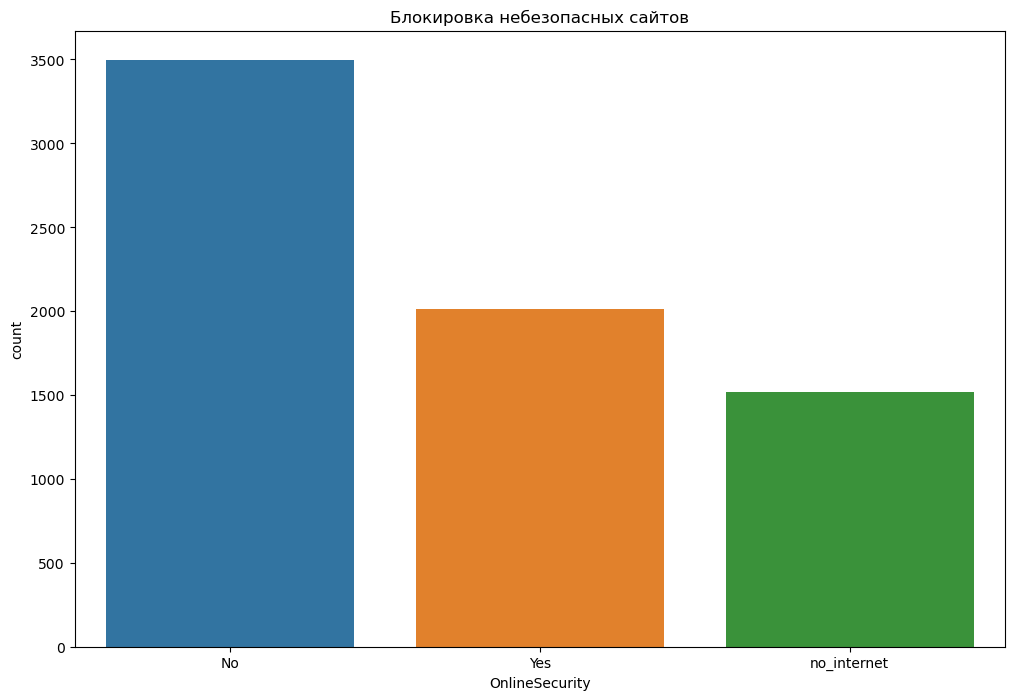

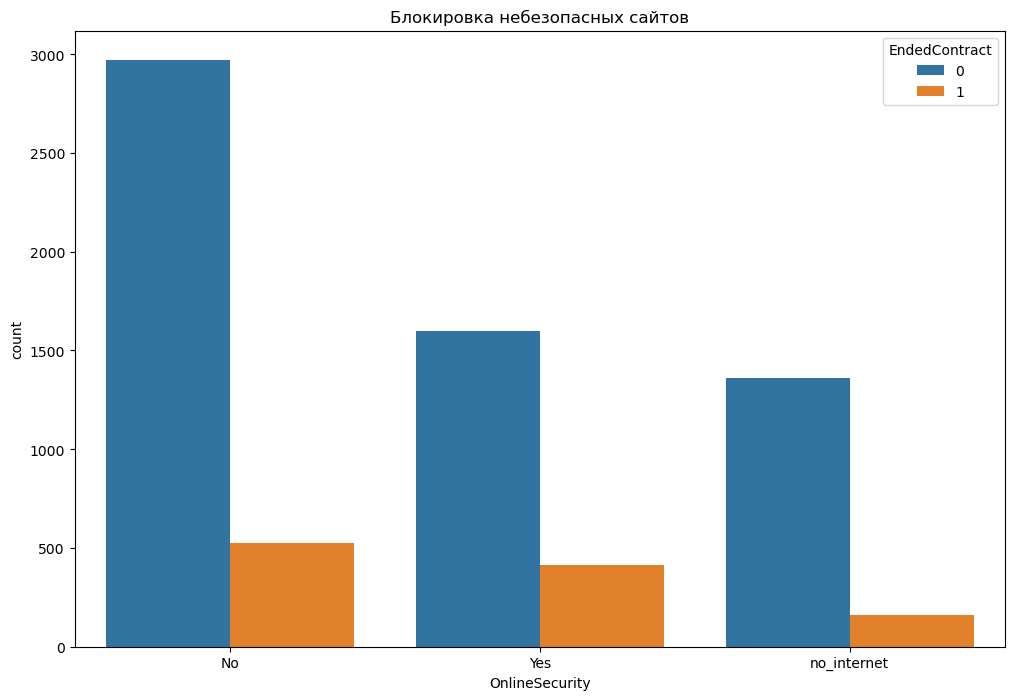

Относительное число пользователей, отказавшихся от услуг:

        No:
        	Отказались от услуг: 15.04%
        	Не отказались от услуг: 84.96%

        Yes:
        	Отказались от услуг: 20.6%
        	Не отказались от услуг: 79.4%

        no_internet:
        	Отказались от услуг: 10.53%
        	Не отказались от услуг: 89.47%


In [61]:
analyse_categorical_feature('OnlineSecurity', 'Блокировка небезопасных сайтов')

Большинство пользователей не пользуются услугой блокировки небезопасных сайтов. При этом, среди тех, кто все-таки пользуется этой услугой, выше процент отказа от услуг.

#### Призак `OnlineBackup`

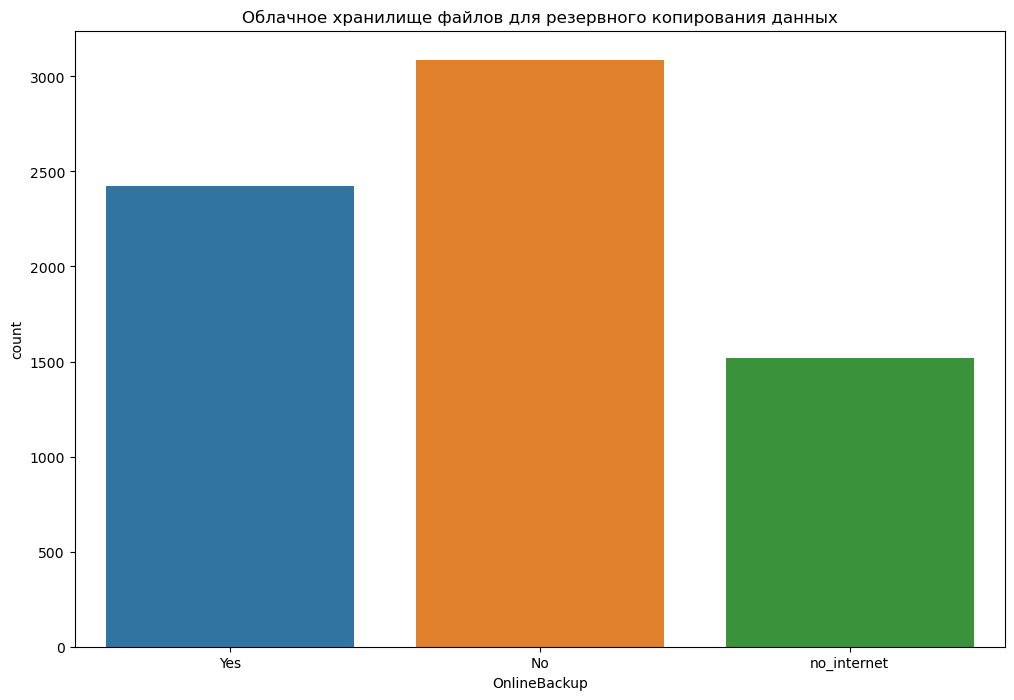

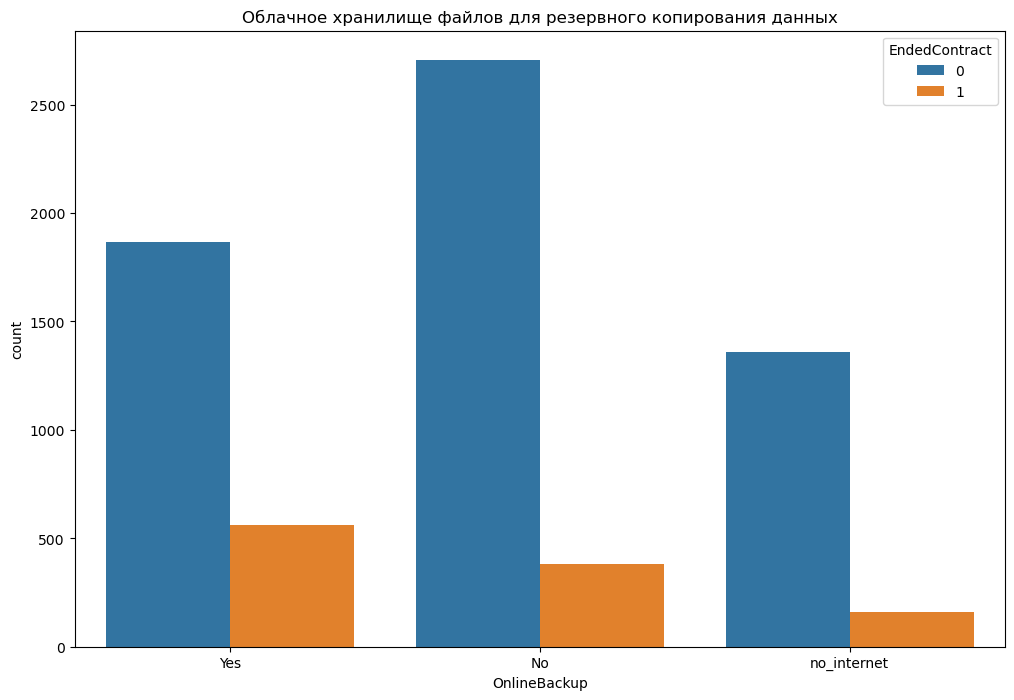

Относительное число пользователей, отказавшихся от услуг:

        Yes:
        	Отказались от услуг: 23.09%
        	Не отказались от услуг: 76.91%

        No:
        	Отказались от услуг: 12.34%
        	Не отказались от услуг: 87.66%

        no_internet:
        	Отказались от услуг: 10.53%
        	Не отказались от услуг: 89.47%


In [62]:
analyse_categorical_feature('OnlineBackup', 'Облачное хранилище файлов для резервного копирования данных')

Большинство пользователей не пользуются услугой, а те, кто пользуются, чаще отказываются от услуг.

#### Признак `DeviceProtection`

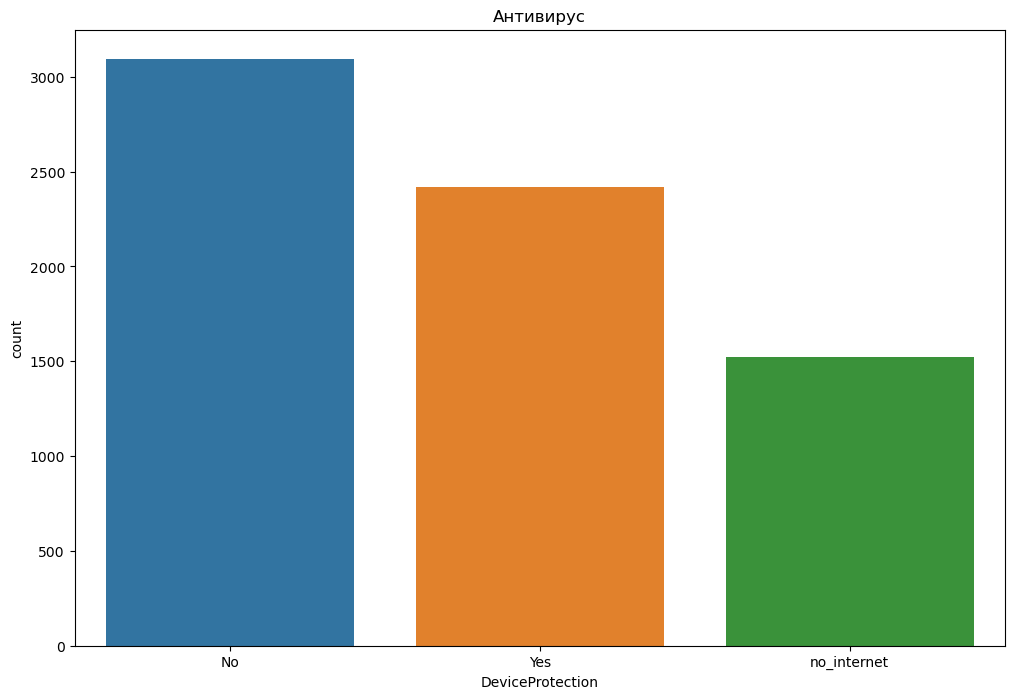

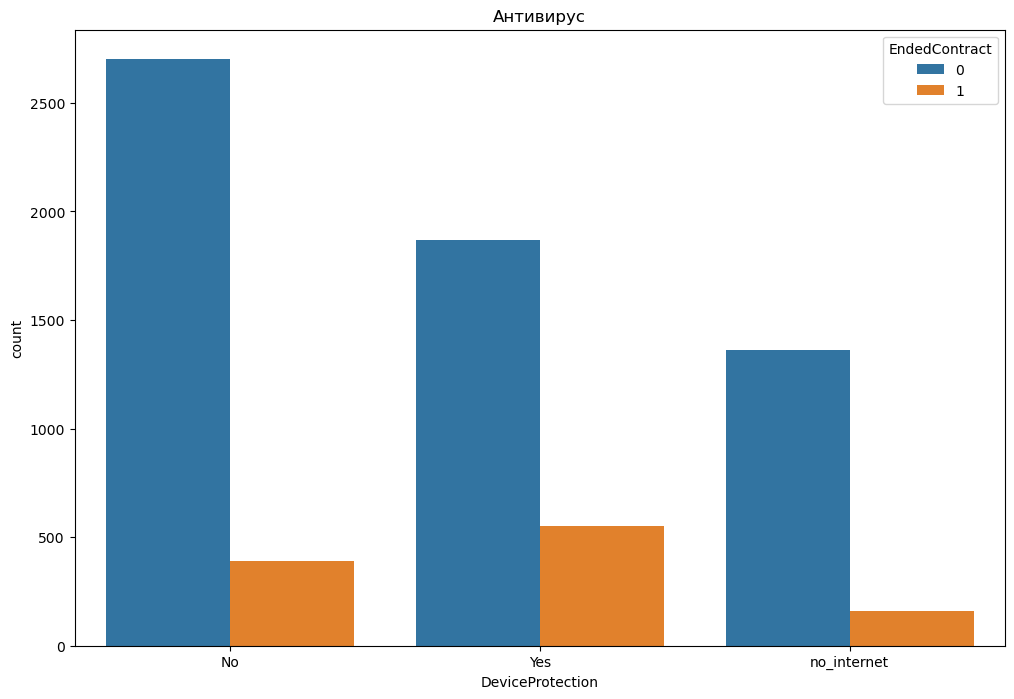

Относительное число пользователей, отказавшихся от услуг:

        No:
        	Отказались от услуг: 12.64%
        	Не отказались от услуг: 87.36%

        Yes:
        	Отказались от услуг: 22.75%
        	Не отказались от услуг: 77.25%

        no_internet:
        	Отказались от услуг: 10.53%
        	Не отказались от услуг: 89.47%


In [63]:
analyse_categorical_feature('DeviceProtection', 'Антивирус')

Большинство пользователей не пользуются антивирусом, а те, кто пользуются, чаще отказываются от услуг.

#### Признак `TechSupport`

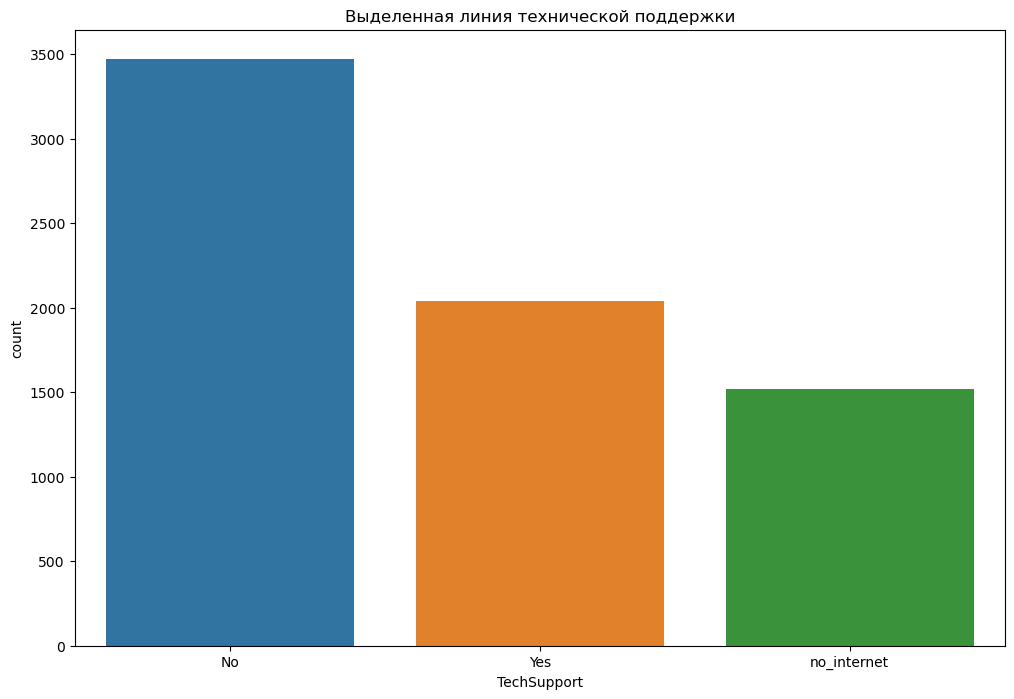

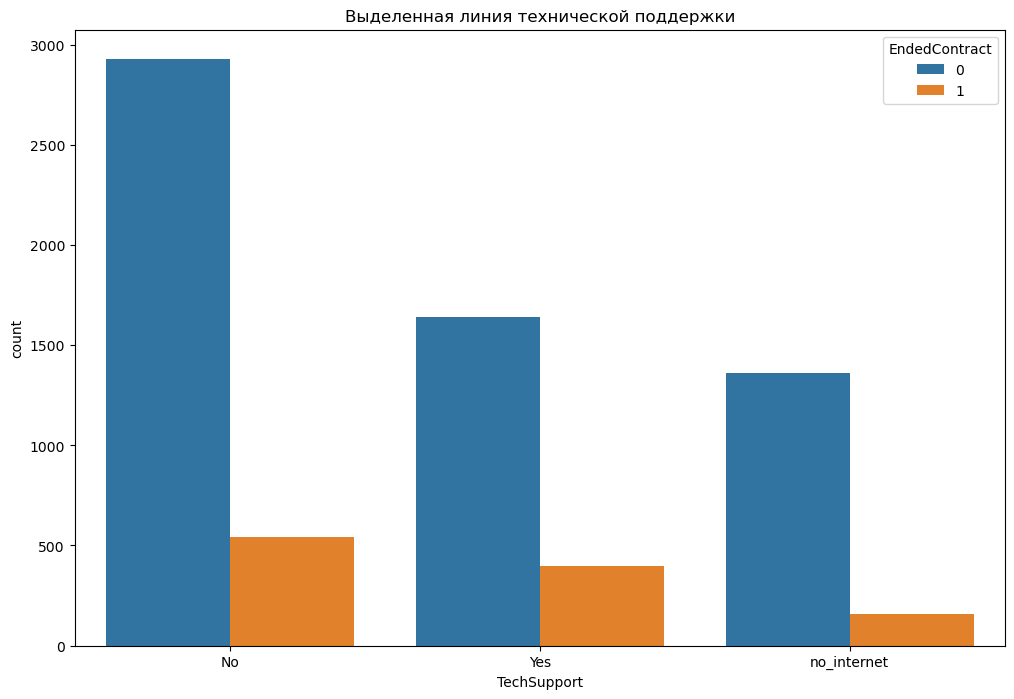

Относительное число пользователей, отказавшихся от услуг:

        No:
        	Отказались от услуг: 15.64%
        	Не отказались от услуг: 84.36%

        Yes:
        	Отказались от услуг: 19.51%
        	Не отказались от услуг: 80.49%

        no_internet:
        	Отказались от услуг: 10.53%
        	Не отказались от услуг: 89.47%


In [64]:
analyse_categorical_feature('TechSupport', 'Выделенная линия технической поддержки')

Большинство пользователей не пользуются услугой, а те, кто пользуются, немного чаще отказываются от услуг.

#### Признак `StreamingTV`

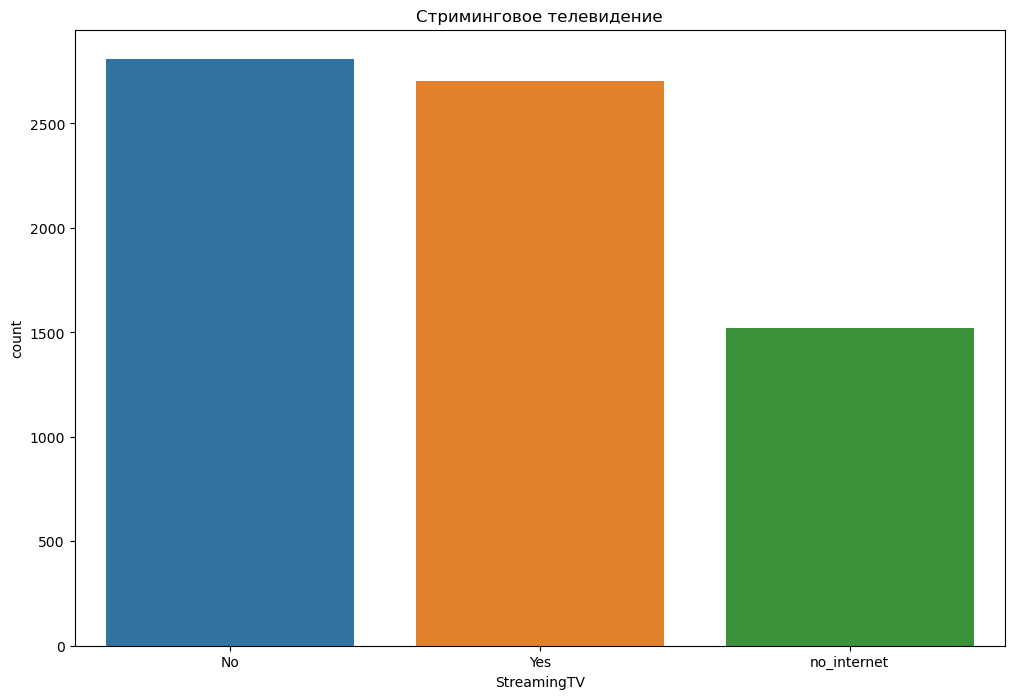

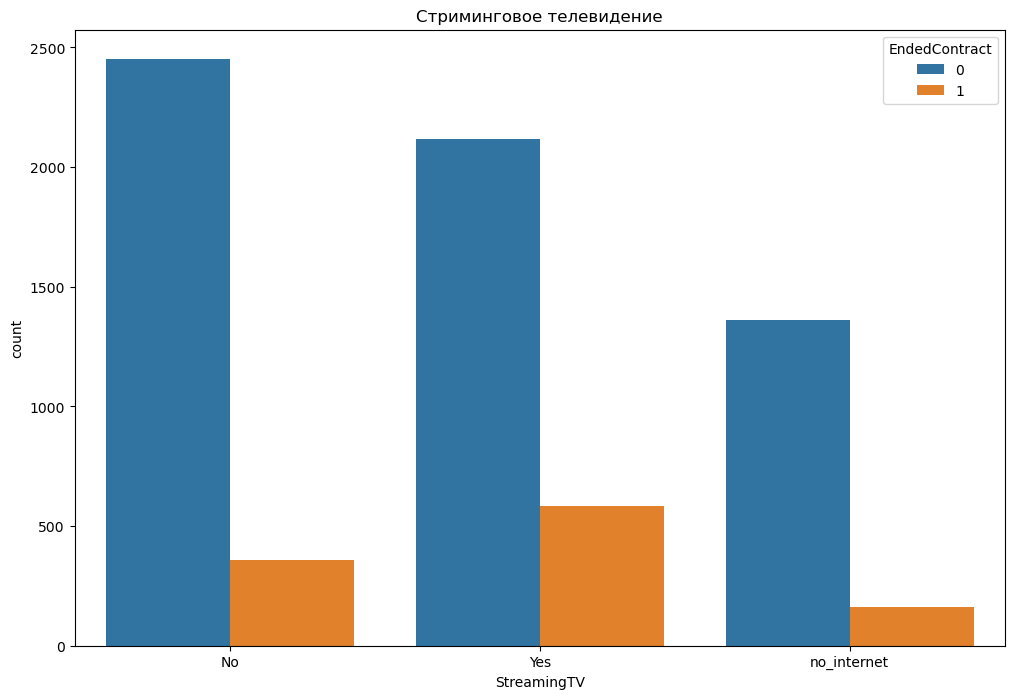

Относительное число пользователей, отказавшихся от услуг:

        No:
        	Отказались от услуг: 12.71%
        	Не отказались от услуг: 87.29%

        Yes:
        	Отказались от услуг: 21.61%
        	Не отказались от услуг: 78.39%

        no_internet:
        	Отказались от услуг: 10.53%
        	Не отказались от услуг: 89.47%


In [65]:
analyse_categorical_feature('StreamingTV', 'Стриминговое телевидение')

Примерно одинаковое количество пользователей пользуются стриминговым телевидением, однако снова видна тенденция к отказу от услуг у тех пользователей, которые пользуются дополнительными услугами.

#### Признак `StreamingMovies`

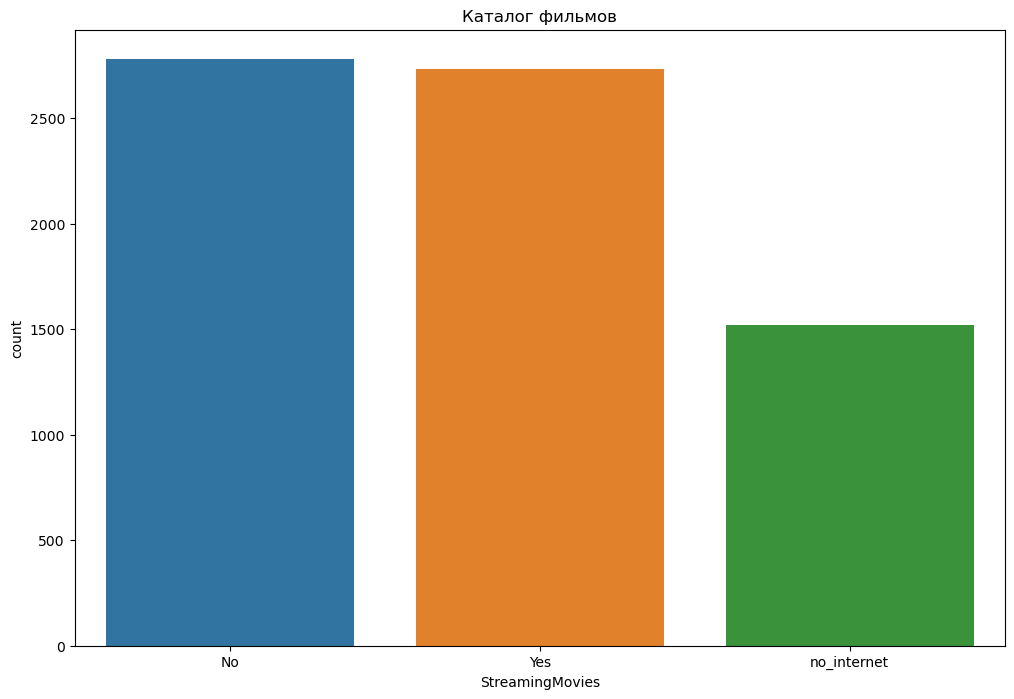

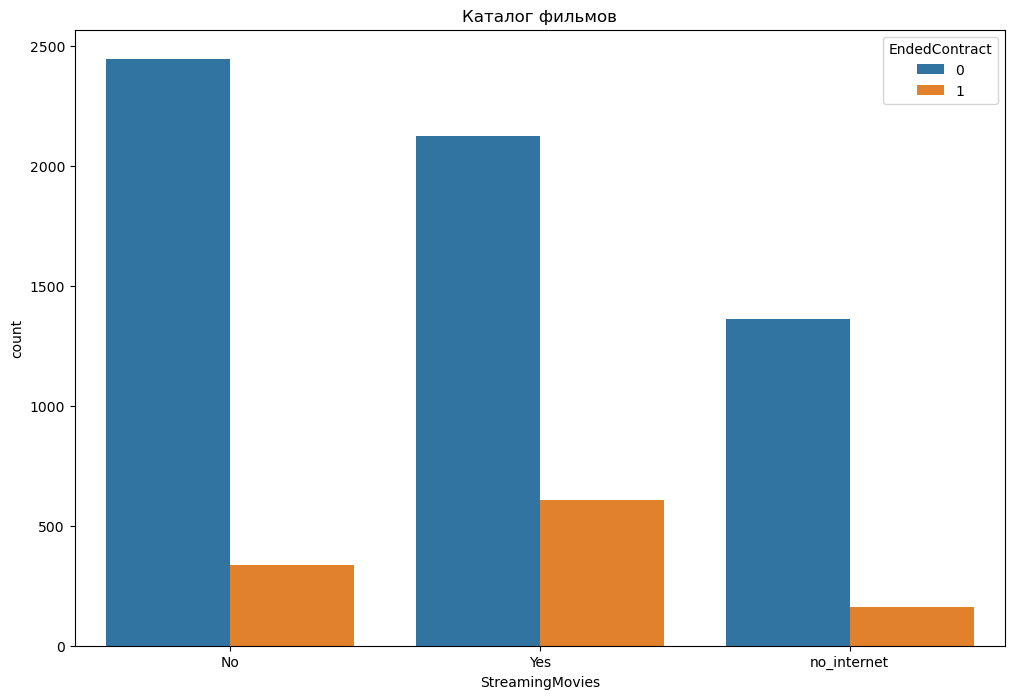

Относительное число пользователей, отказавшихся от услуг:

        No:
        	Отказались от услуг: 12.05%
        	Не отказались от услуг: 87.95%

        Yes:
        	Отказались от услуг: 22.19%
        	Не отказались от услуг: 77.81%

        no_internet:
        	Отказались от услуг: 10.53%
        	Не отказались от услуг: 89.47%


In [66]:
analyse_categorical_feature('StreamingMovies', 'Каталог фильмов')

При примерно одинаковом количестве пользователей подключивших и не подключивших каталог фильмов, чаще от услуг отказываются пользователи, подключившие дополнительную услугу.

#### Признак `MultipleLines`

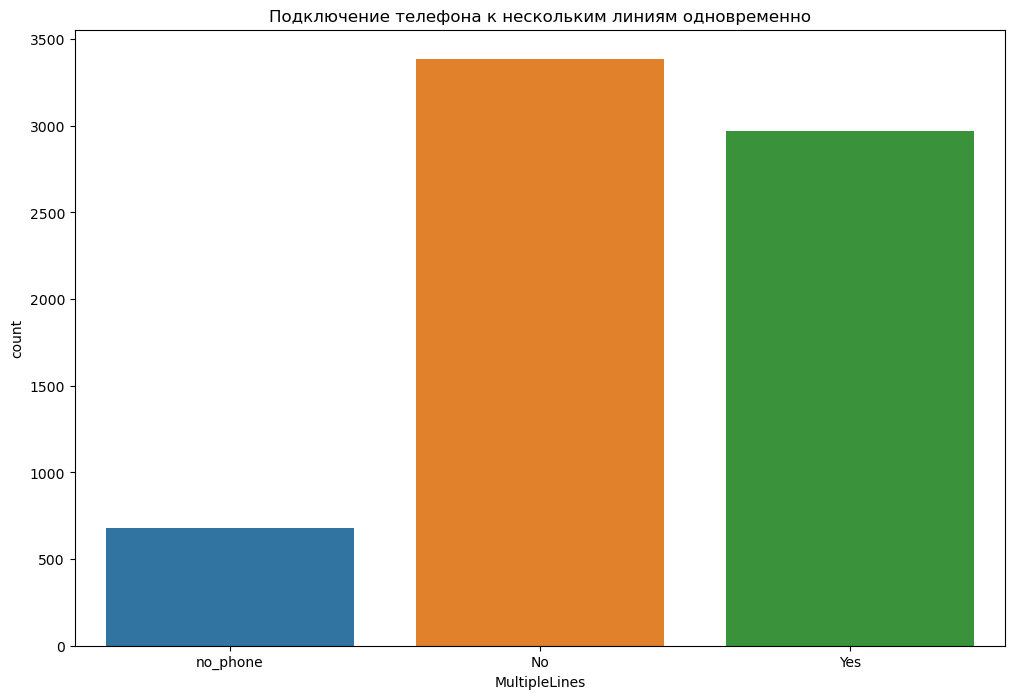

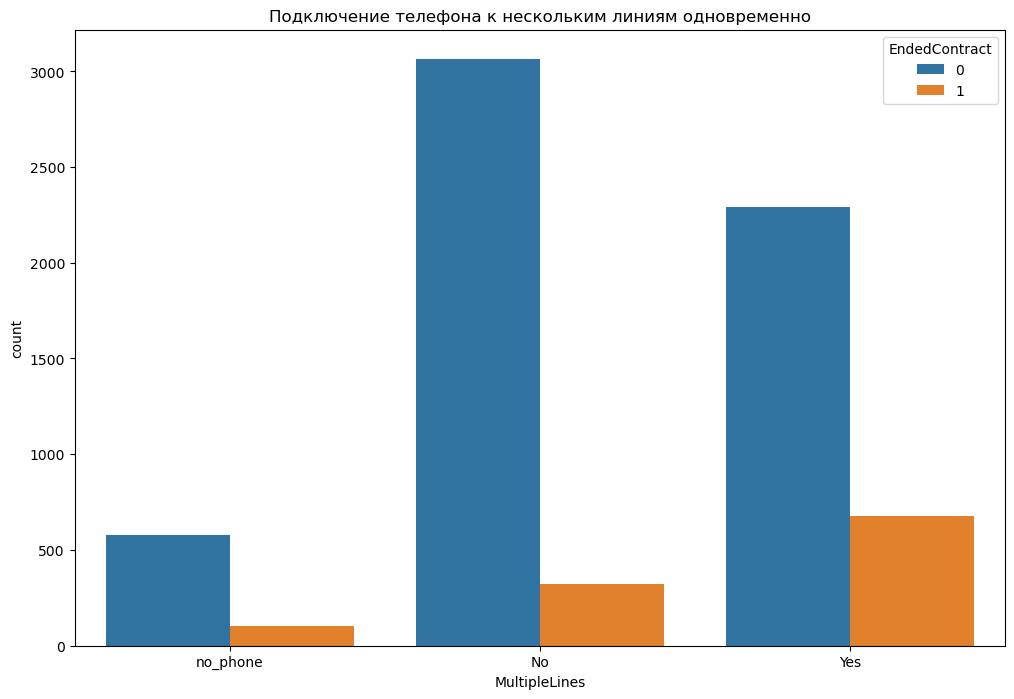

Относительное число пользователей, отказавшихся от услуг:

        no_phone:
        	Отказались от услуг: 15.15%
        	Не отказались от услуг: 84.85%

        No:
        	Отказались от услуг: 9.45%
        	Не отказались от услуг: 90.55%

        Yes:
        	Отказались от услуг: 22.85%
        	Не отказались от услуг: 77.15%


In [67]:
analyse_categorical_feature('MultipleLines', 'Подключение телефона к нескольким линиям одновременно')

Пользователи, подключившие услугу подключения телефона к нескольким линиям одновременно, чаще отказываются от услуг компании.

Анализ категориальных признаков показал, что пользователи, которые подключают дополнительные услуги, чаще отказываются от услуг компании.

#### Признак `MonthlyCharges`

In [68]:
def analyse_interval_feature(feature_name: str, plt_name: str = None):
    """Функция для визуализации информации об интервальных признаках"""
    fig, ax = plt.subplots(figsize=(12,8))  
    data_all[feature_name].hist()
    plt.title(plt_name)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12,8)) 
    sns.histplot(data_all, x=feature_name, hue='EndedContract', element="step")
    plt.title(plt_name)
    plt.show()
    
    print(f'Статистическое описание признака {feature_name}:')
    display(data_all[feature_name].describe())
    
    print(f'Статистическое описание признака {feature_name} для пользователей, отказавшихся от услуг:')
    display(data_all[data_all['EndedContract'] == 1][feature_name].describe())
    
    print(f'Статистическое описание признака {feature_name} для пользователей, продолживших пользоваться услугами:')
    display(data_all[data_all['EndedContract'] == 0][feature_name].describe())

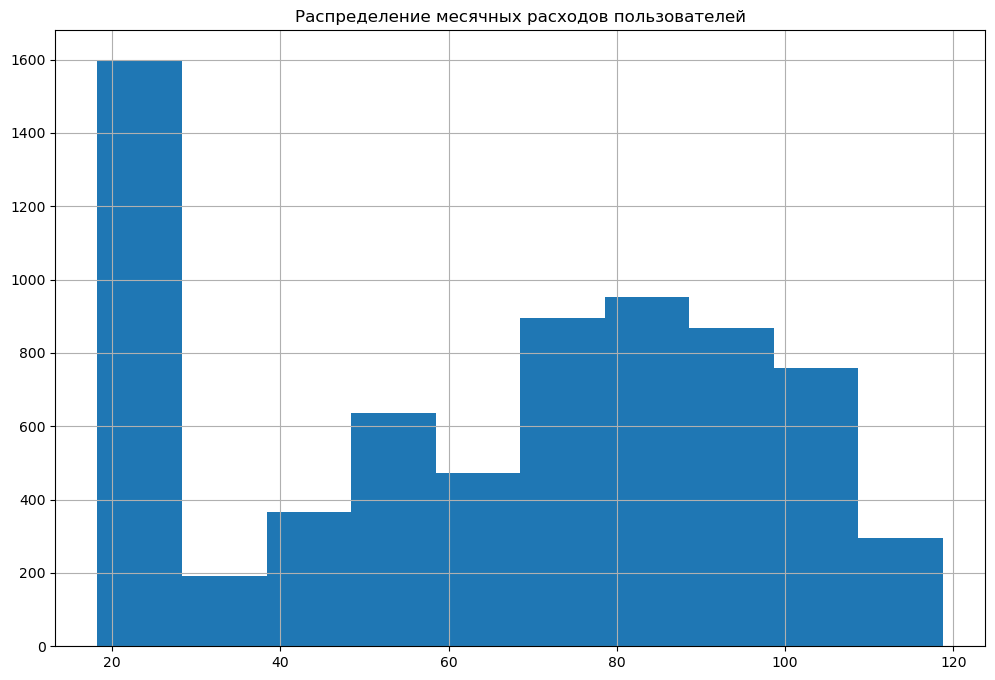

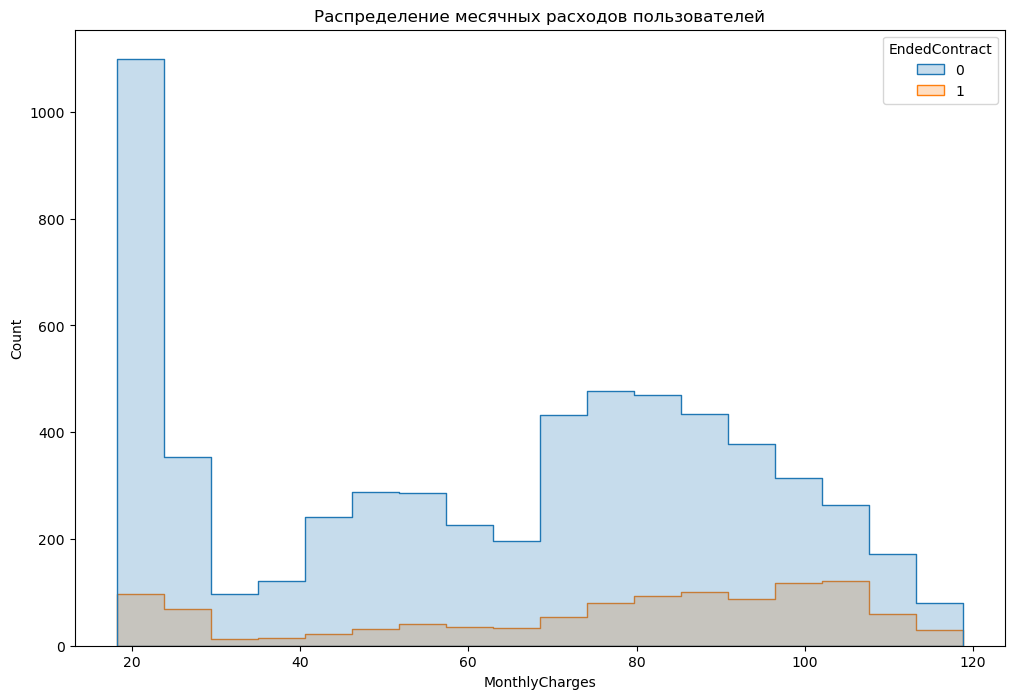

Статистическое описание признака MonthlyCharges:


count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

Статистическое описание признака MonthlyCharges для пользователей, отказавшихся от услуг:


count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: MonthlyCharges, dtype: float64

Статистическое описание признака MonthlyCharges для пользователей, продолживших пользоваться услугами:


count    5931.000000
mean       62.803043
std        29.841911
min        18.250000
25%        30.125000
50%        69.250000
75%        87.325000
max       118.600000
Name: MonthlyCharges, dtype: float64

In [69]:
analyse_interval_feature('MonthlyCharges', 'Распределение месячных расходов пользователей')

Мы можем видеть, что у пользоваталей, отказавшихся от услуг компании, среднее и медианное значения месячных затрат (75.6 и 84.2 соответственно) выше чем у пользоваталей, не разорвавших контракт (62.8 и 69.3). Это соотносится с наблюдением о том, что пользователи, подключающие б*о*льшее количество услуг, чаще расторгают контракт с компанией. 

#### Признак `TotalCharges`

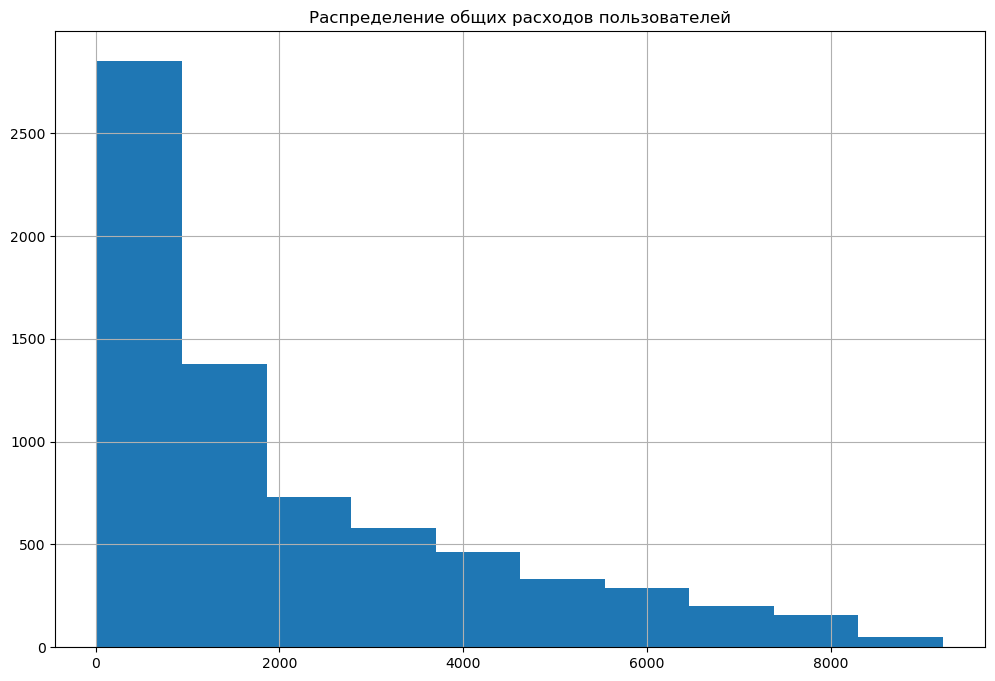

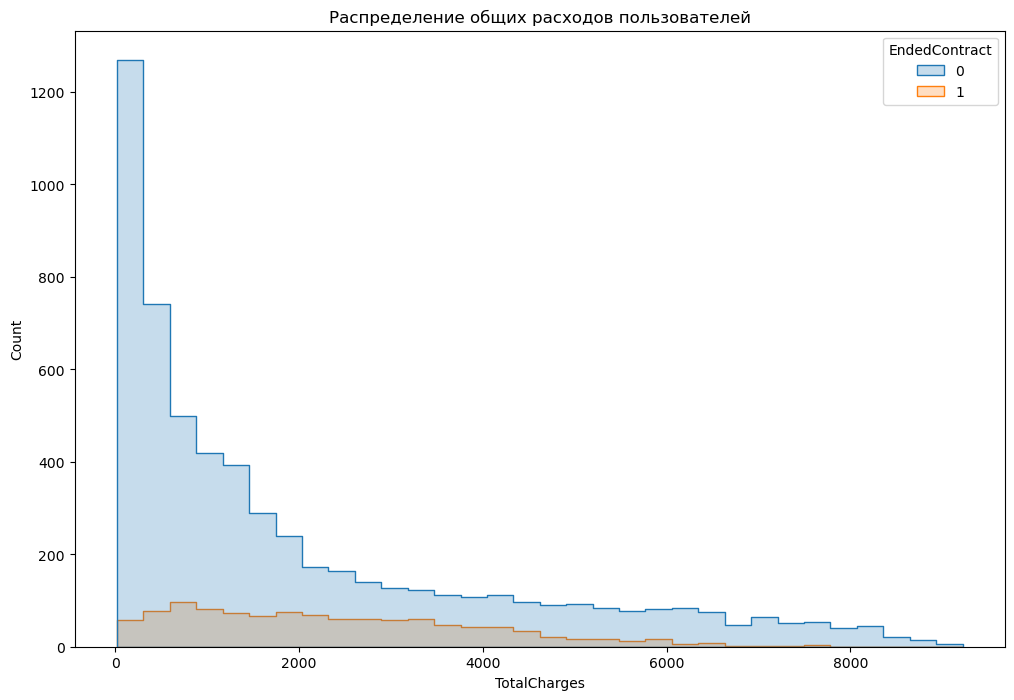

Статистическое описание признака TotalCharges:


count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

Статистическое описание признака TotalCharges для пользователей, отказавшихся от услуг:


count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: TotalCharges, dtype: float64

Статистическое описание признака TotalCharges для пользователей, продолживших пользоваться услугами:


count    5931.000000
mean     2071.701614
std      2194.122190
min        19.050000
25%       376.225000
50%      1194.280000
75%      3176.000000
max      9221.380000
Name: TotalCharges, dtype: float64

In [70]:
analyse_interval_feature('TotalCharges', 'Распределение общих расходов пользователей')

Видим, что у пользователей, отказавшихся от услуг компании, среднее и медианное значения общих затрат (2371.4 и 2139 соответственно) выше чем у пользоваталей, не разорвавших контракт (2071.7 и 1194.3). У пользователей, отказавшихся от услуг компании, также выше минимальное значение общих затрат. Это соотносится с наблюдением о том, что пользователи, подключающие б*о*льшее количество услуг, чаще расторгают контракт с компанией.

#### Признак `ContractLength`

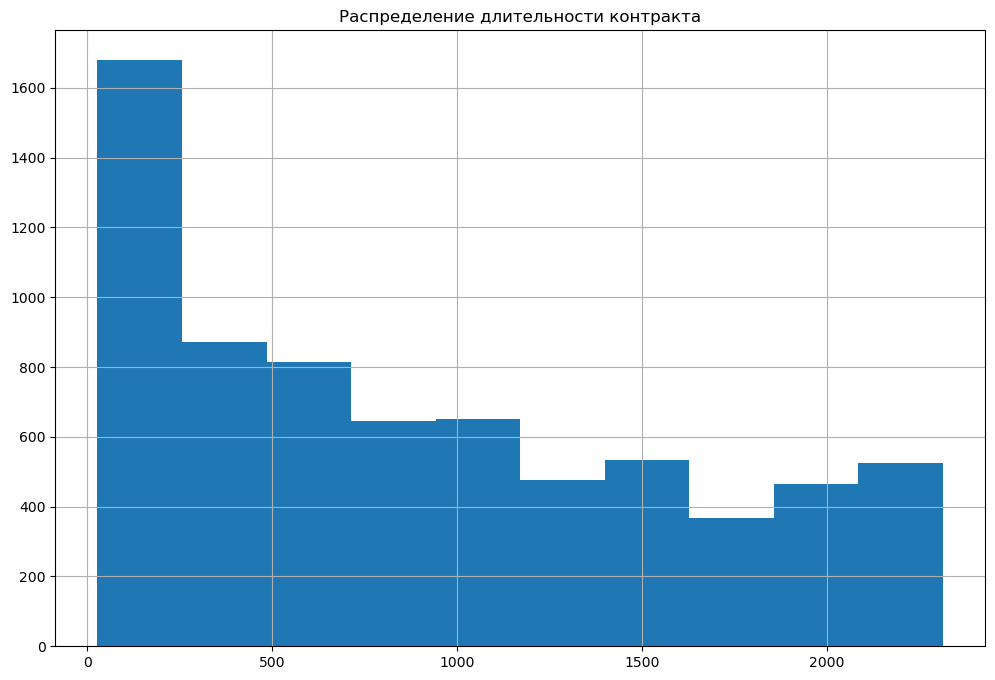

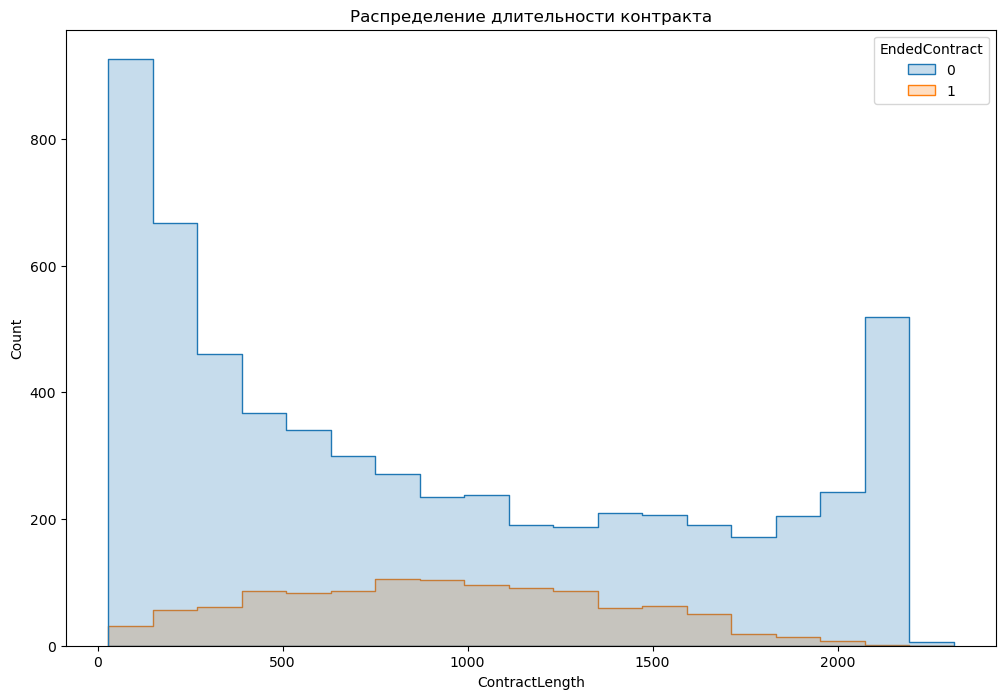

Статистическое описание признака ContractLength:


count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: ContractLength, dtype: float64

Статистическое описание признака ContractLength для пользователей, отказавшихся от услуг:


count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: ContractLength, dtype: float64

Статистическое описание признака ContractLength для пользователей, продолживших пользоваться услугами:


count    5931.000000
mean      895.338560
std       716.588322
min        31.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: ContractLength, dtype: float64

In [71]:
analyse_interval_feature('ContractLength', 'Распределение длительности контракта')

In [72]:
data_all['ContractLength'].mode()

0    2191
Name: ContractLength, dtype: int64

In [73]:
data_all[data_all['EndedContract'] == 1]['ContractLength'].mode()

0    1461
Name: ContractLength, dtype: int64

In [74]:
data_all[data_all['EndedContract'] == 0]['ContractLength'].mode()

0    2191
Name: ContractLength, dtype: int64

Видим, что пользователи, которые не отказываются от услуг компании, либо относительно недавно стали клиентами компании (в течение года), либо являются клиентами компании уже более пяти лет (более 2000 дней). В то же время, пользователи расторгают контракт после 1.5 лет пользования услугами компании. На интервале в 500-1500 дней идет увеличение количества отказов и уменьшение количества пользователей, продолжающих пользоваться услугами компании.

#### Изучение корреляции признаков

In [75]:
data_corr = data_all.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'ContractLength'])

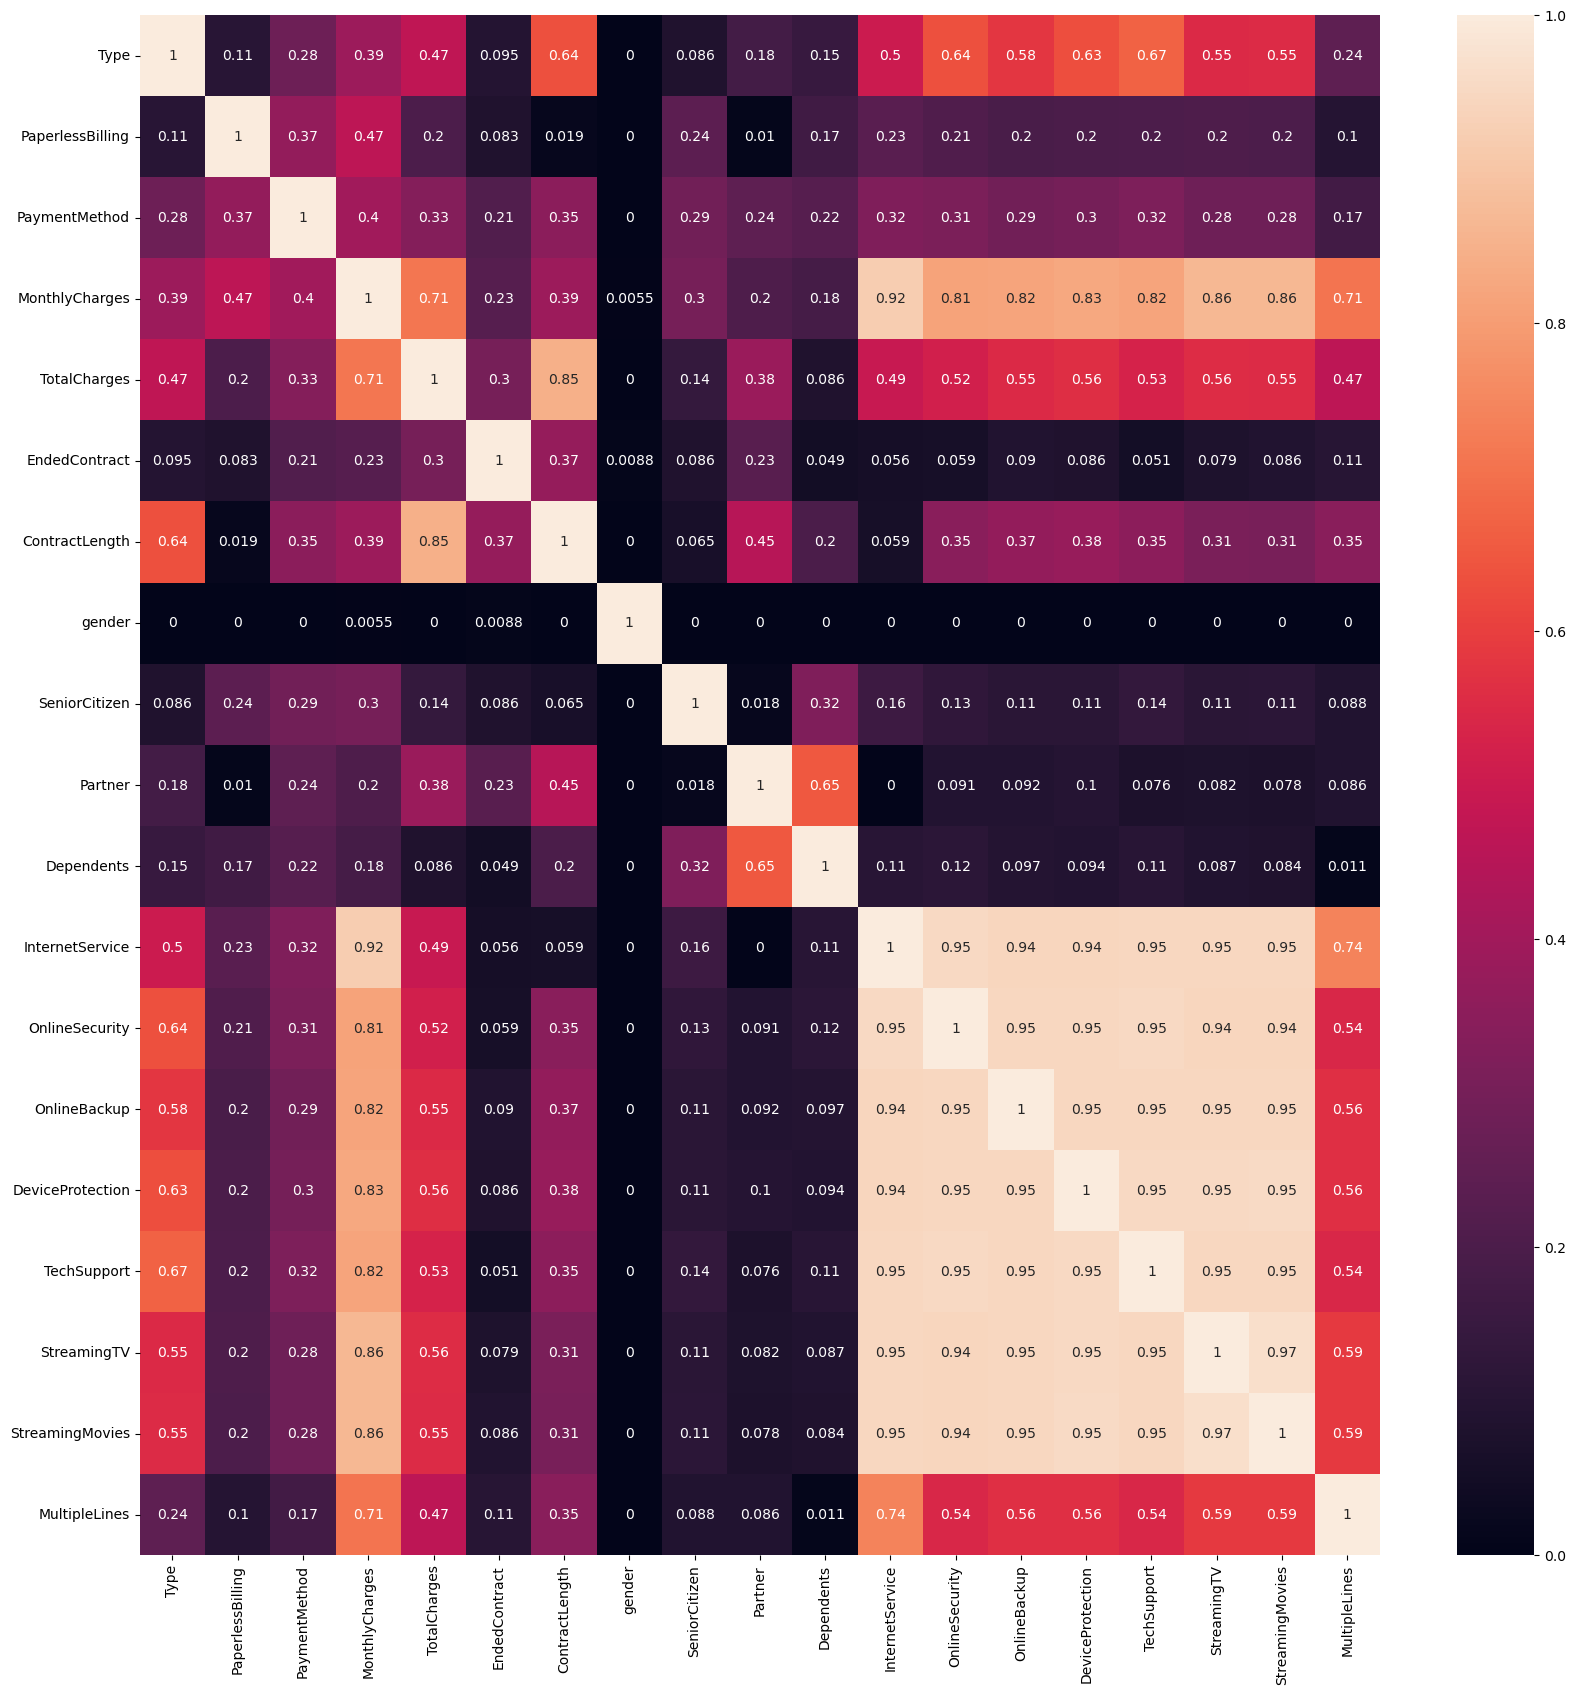

In [76]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(data_corr, annot=True)
plt.show()


Сначала посмотрим, какие признаки сильнее всего коррелируют с нашим целевым признаком `EndedContract`. Это следующие признаки:
- `ContractLength`: $\phi_k = 0.37$
- `TotalCharges`: $\phi_k = 0.3$
- `MonthlyCharges`: $\phi_k = 0.23$
- `Partner`: $\phi_k = 0.23$
- `PaymentMethod`: $\phi_k = 0.21$

Далее стоит изучить не целевые признаки, которые сильно коррелируют друг с другом. Возьмем в качестве порогового значения 0.8.

In [77]:
for column in data_corr.columns:
    column_corr = data_corr[(abs(data_corr) >= 0.8) & (abs(data_corr) < 1)][column]
    if (~column_corr.isna()).sum() >= 0.8: 
        print(f'Признаки, которые сильно коррелируют с {column}:')
        print(column_corr[~column_corr.isna()])
        print()

Признаки, которые сильно коррелируют с MonthlyCharges:
InternetService     0.919005
OnlineSecurity      0.812548
OnlineBackup        0.818861
DeviceProtection    0.827363
TechSupport         0.816645
StreamingTV         0.864821
StreamingMovies     0.863544
Name: MonthlyCharges, dtype: float64

Признаки, которые сильно коррелируют с TotalCharges:
ContractLength    0.847572
Name: TotalCharges, dtype: float64

Признаки, которые сильно коррелируют с ContractLength:
TotalCharges    0.847572
Name: ContractLength, dtype: float64

Признаки, которые сильно коррелируют с InternetService:
MonthlyCharges      0.919005
OnlineSecurity      0.949461
OnlineBackup        0.942839
DeviceProtection    0.942811
TechSupport         0.948878
StreamingTV         0.946750
StreamingMovies     0.946275
Name: InternetService, dtype: float64

Признаки, которые сильно коррелируют с OnlineSecurity:
MonthlyCharges      0.812548
InternetService     0.949461
OnlineBackup        0.947213
DeviceProtection    0.946776
T

Для того, чтобы избежать мультиколлинеарности, предлагаю удалить из данных признаки `InternetService`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, т.к. они сильно коррелируют друг с другом и признаком `MonthlyCharges`.
Также предлагаю удалить признак `TotalCharges`, т.к. он сильно коррелирует с признаком `ContractLength`, при этом последний б*о*льше коррелирует с целевым признаком.

In [78]:
data = data_all.drop(['InternetService', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                      'StreamingMovies', 'TotalCharges'], axis=1)

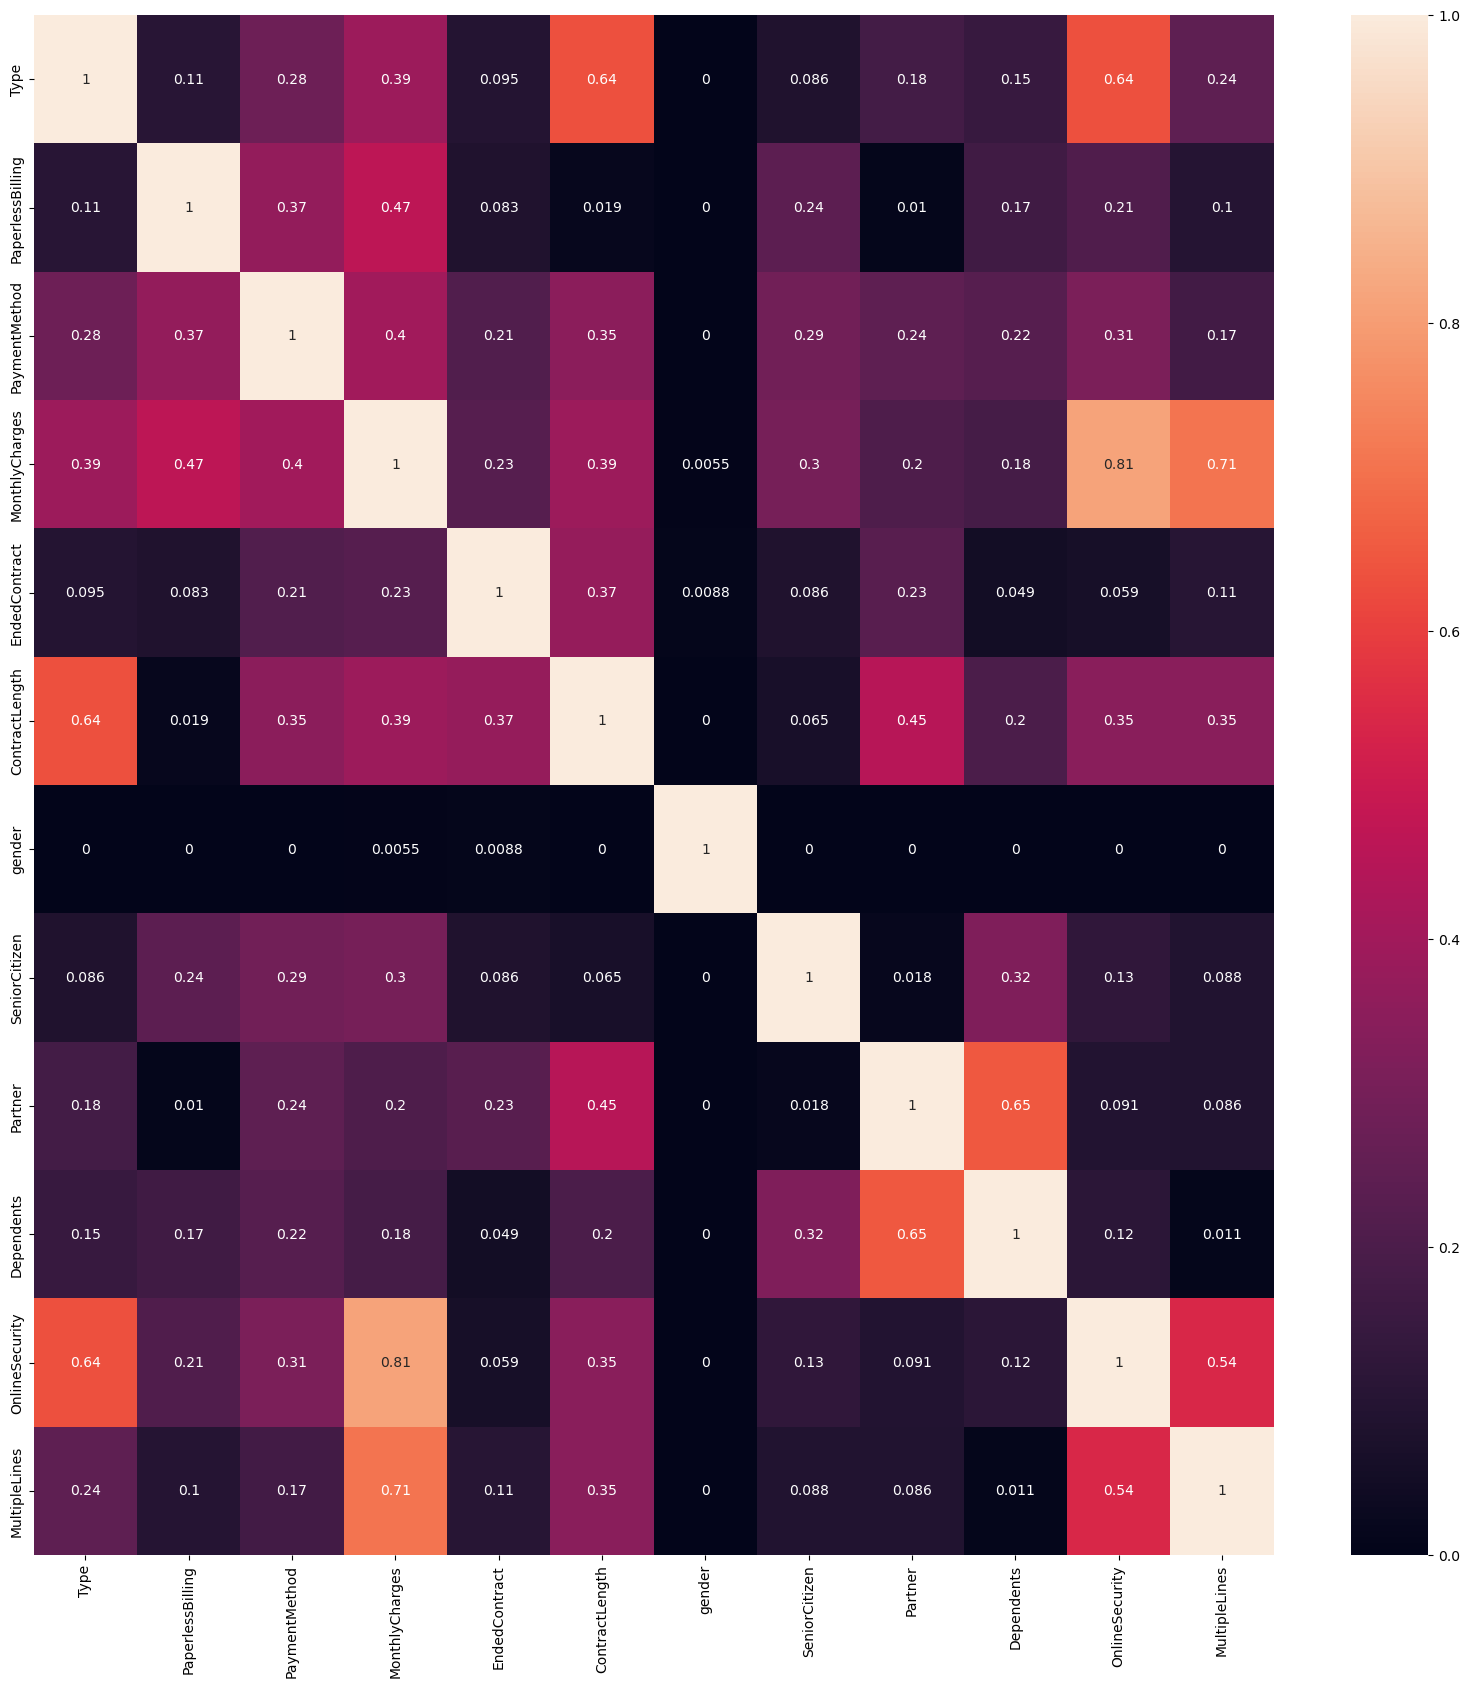

In [79]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(data.phik_matrix(interval_cols=['MonthlyCharges', 'ContractLength']), annot=True)
plt.show()

Таким образом, с целевым признаком `EndedContract` больше всего коррелируют следующие признаки:
- `ContractLength`: $\phi_k = 0.37$
- `MonthlyCharges`: $\phi_k = 0.23$
- `Partner`: $\phi_k = 0.23$
- `PaymentMethod`: $\phi_k = 0.21$

### Выводы по этапу исследовательского анализа данных

Был проведен исследовательский анализ данных и обнаружены следующие закономерности:
1. В данных наблюдается дизбаланс классов по целевому признаку: 85% пользователей не отказались от услуг компании.
2. Наблюдается тенденция к отказу от услуг теми пользователями, у которых подключено подключено больше дополнительных услуг. У этих же пользователей, закономерно, выше месячная плата за услуги. Было обнаружено, что эти признаки сильно коррелируют друг с другом, поэтому в дальнейшем было принято решение работать только с признаком `MonthlyCharges`.
3. Пользователи, которые только заключили контаркт или заключили его более 5 лет назад, менее склонны к тому, чтобы разрывть контракт. В то же время, пользователи, которые пользуются услугами компании от 1.5 до 5 лет, более слонны к тому, чтобы отказаться от услуг.
4. Признак `TotalCharges` сильно коррелирует с признаком `ContractLength`, поэтому он также был удален из данных.
5. С с целевым признаком `EndedContract` больше всего коррелируют следующие признаки:
- `ContractLength`: $\phi_k = 0.37$
- `MonthlyCharges`: $\phi_k = 0.23$
- `Partner`: $\phi_k = 0.23$
- `PaymentMethod`: $\phi_k = 0.21$

## Подготовка данных

Выделим целевой признак и признаки для обучения.

In [80]:
target = data['EndedContract']
features = data.drop(['EndedContract'], axis=1)

Для разбиения данных на обучающую и тестовую выборки в отношении 3:1 (75%:25%) используем функцию train_test_split библиотеки `sklearn`.

In [81]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [82]:
for df in [features_train, features_test, target_train, target_test]:
    print(df.shape)

(5274, 11)
(1758, 11)
(5274,)
(1758,)


Также определим `OneHotEncoder` для кодирования категориальных признаков.

In [83]:
encoder = OrdinalEncoder()

In [84]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                        'OnlineSecurity', 'MultipleLines']
numerical_features = ['MonthlyCharges', 'ContractLength']

In [85]:
ct = ColumnTransformer(transformers = [("encoder", encoder, categorical_features)], remainder='passthrough')

## Обучение моделей машинного обучения

### RandomForestClassifier
Сначала исследуем модель случайного леса.

In [86]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

In [87]:
pipe_rfc = Pipeline(steps=[("encoder", ct), ("rfc", rfc)])

In [88]:
param_grid_rfc = {
    "rfc__n_estimators": [50, 100, 150],
    "rfc__max_depth": [None, 10, 20],
    "rfc__max_features": ['sqrt', 'log2', None]
}

In [89]:
search = GridSearchCV(estimator=pipe_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=-1)

In [90]:
%%time
search.fit(features_train, target_train)

CPU times: total: 2.02 s
Wall time: 20.8 s


GridSearchCV(estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OrdinalEncoder(),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'MultipleLines'])])),
                                       ('rfc',
                                        RandomForestClassifier(random_state=301023))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [None, 10, 20],
                         'rfc__max_features': ['sqrt', 'log2', None],
                         'rfc__n_estimators': [50, 100, 150]},
             scoring='roc_auc')

In [91]:
print(search.best_params_)

{'rfc__max_depth': 10, 'rfc__max_features': None, 'rfc__n_estimators': 150}


In [92]:
print("Лучшее качество на кросс-валидации roc_auc_score = %0.3f" % search.best_score_)

Лучшее качество на кросс-валидации roc_auc_score = 0.835


### LGBMClassifier

In [93]:
lgbm = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)

In [94]:
param_grid_lgbm = {
    "lgbm__max_depth": [-1, 10, 20],
    "lgbm__learning_rate": [0.05, 0.01],
    "lgbm__n_estimators": [100, 200, 250],
#     'lgbm__num_threads':[1] #Код ревьюера
}

In [95]:
pipe_lgbm = Pipeline(steps=[("encoder", ct), ("lgbm", lgbm)])

In [96]:
search_lgbm = GridSearchCV(estimator=pipe_lgbm, param_grid=param_grid_lgbm, scoring='roc_auc', n_jobs=-1)

In [97]:
%%time
search_lgbm.fit(features_train, target_train)

CPU times: total: 3.06 s
Wall time: 21.9 s


GridSearchCV(estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OrdinalEncoder(),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'MultipleLines'])])),
                                       ('lgbm',
                                        LGBMClassifier(n_jobs=-1,
                                                       random_state=301023,
                                                       verbose=-1))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.05, 0.01],
                         'lgbm__max_depth': [-1, 10, 20],
                         'lgbm__n_estimators': [100, 200, 250]},
             scoring='roc_auc')

In [98]:
print(search_lgbm.best_params_)

{'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 20, 'lgbm__n_estimators': 250}


In [99]:
print("Лучшее качество на кросс-валидации roc_auc_score = %0.3f" % search_lgbm.best_score_)

Лучшее качество на кросс-валидации roc_auc_score = 0.890


In [100]:
best_model = search_lgbm.best_estimator_

Был произведен подбор параметров, обучение и валидация двух типов моделей:
- модель случайного леса
- модель градиентного бустинга

Наилучшее качество продемонстрировала модель градиентного бустинга с гиперпараметрами `learning_rate` = 0.05, `max_depth` = 20, `n_estimators` = 250. На кросс-валидации было получено значение метрики roc_auc = 0.890.

Изучим, какие признаки оказались самыми важными при обучении модели.

In [101]:
feat_imp = pd.DataFrame(best_model.steps[1][1].feature_importances_, 
                        index=best_model.steps[0][1].get_feature_names_out(), columns=['feature_importance'])

In [102]:
feat_imp.style.background_gradient('coolwarm')

,feature_importance
encoder__Type,291
encoder__PaperlessBilling,135
encoder__PaymentMethod,318
encoder__gender,209
encoder__SeniorCitizen,67
encoder__Partner,205
encoder__Dependents,205
encoder__OnlineSecurity,131
encoder__MultipleLines,174
remainder__MonthlyCharges,1957


Видим, что самыми значимыми признаками оказались `ContractLength` и `MonthlyCharges`, что соотносится с предварительными результатами анализа данных.

## Тестирование модели
Протестируем наилучшенную из обученных моделей.

In [103]:
predicted_probabilites = best_model.predict_proba(features_test)

In [104]:
roc_auc = roc_auc_score(target_test, predicted_probabilites[:, 1])

In [105]:
print('ROC-AUC на тестовой выборке =', round(roc_auc, 3))

ROC-AUC на тестовой выборке = 0.916


In [106]:
best_model.score(features_test, target_test)

0.9175199089874858

Качество классификации на тестовой выборке roc_auc_score = 0.916. Accuracy на тестовой выборке = 0.917.

## Общий вывод и рекомендации заказчику

Была обучена модель классификации, прогнозирующая отток клиентов. Для выполнения этой задачи были выполнены следующие шаги:
1. Загрузка данных в датафреймы `contracts`, `personal`, `internet`, `phone`.
2. Предварительное исследование данных в этих датафреймах.
    - Датайрейм `contracts`. Мы удалили неявные дубликаты в колонке `TotalCharges`, преобразовали данные к типу `datetime` в колонке `EndTime`, привели данные в колонке `TotalCharges` к типу `float` и выделили два новых признака: целевой признак `EndedContract` и признак `ContractLength`.
    - Датафрейм `personal`. Значения в колонке `SeniorCitizen` были заменены на `Yes` и `No`. Была проведена проверка на наличие неявных дубликатов.
    - Датафрейм `internet`. Была проведена проверка на наличие неявных дубликатов.
    - Датафрейм `phone`. Была проведена проверка на наличие неявных дубликатов.
3. Объединение датафреймов в единый датафрейм `data_all` размерностью (7032, 22).
4. Исследовательский анализ данных. были выявлены следующие закономерности:
    - В данных наблюдается дизбаланс классов по целевому признаку: 85% пользователей не отказались от услуг компании.
    - Наблюдается тенденция к отказу от услуг теми пользователями, у которых подключено подключено больше дополнительных услуг. У этих же пользователей, закономерно, выше месячная плата за услуги. Было обнаружено, что эти признаки сильно коррелируют друг с другом, поэтому в дальнейшем было принято решение работать только с признаком `MonthlyCharges`.
    - Пользователи, которые только заключили контаркт или заключили его более 5 лет назад, менее склонны к тому, чтобы разрывть контракт. В то же время, пользователи, которые пользуются услугами компании от 1.5 до 5 лет, более слонны к тому, чтобы отказаться от услуг.
    - Признак `TotalCharges` сильно коррелирует с признаком `ContractLength`, поэтому он также был удален из данных.
    - С с целевым признаком `EndedContract` больше всего коррелируют следующие признаки:
        - `ContractLength`: $\phi_k = 0.37$
        - `MonthlyCharges`: $\phi_k = 0.23$
        - `Partner`: $\phi_k = 0.23$
        - `PaymentMethod`: $\phi_k = 0.21$
5. Подготовка данных. На этом этапе данные были разделены на обучающую и тестовую выборки в отношении 3:1. Также был определен `OrdinalEncoder` для преобразования категориальных признаков.
6. Обучение моделей машинного обучения. Были обучены два типа моделей.
|Модель|Признаки|Наилучшее качество по кросс-валидации|
|------|--------|------------------------------------:|
|RandomForestClassifier|`max_depth`: 10, `max_features`: None, `n_estimators`: 150|0.835|
|LGBMClassifier|`learning_rate`: 0.05, `max_depth`: 20, `n_estimators`: 250|0.890|

    Наилучшее качество продемонстрировала модель градиентного бустинга. Для нее также была изучена важность признаков: самыми важными признакаи оказались признаки `ContractLength` и `MonthlyCharges`, что соотносится с результатами исследовательского анализа данных.

7. Тестирование модели. Модель градиентного бустинга продемонстрировала качество roc_auc_score = 0.916. Accuracy классификации = 0.918.

Исследовательский анализ данных и анализ модели показали, что ключевыми признаками для прогнозирования оттока клиентов являются **длительность контракта** и **расходы за месяц**. Клиенты, у которых высокая месячная оплата за счет большого количества подключенных услуг, с большей вероятностью выберут расторгнуть контракт после 1.5 лет пользования услугами, поэтому имеет смысл обратить внимание именно на этот сегмент клиентской базы.